In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

from utils_w_masking import load_rnacompete_data
import utils_w_masking
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Set seed for reproducibility
utils_w_masking.configure_seed(42)

# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### LSTM (Long Short-Term Memory) model - Bidiretional

In [4]:
from torch.nn.utils.rnn import pack_padded_sequence

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.layer_dim = n_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        # input_dim deve ser 4 (A,C,G,U) pois os dados são One-Hot
        self.lstm = nn.LSTM(input_dim,
                            hidden_dim//2 if bidirectional else hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True) # If set to True, input/output tensors are provided as (batch, seq_len, features) instead of (seq_len, batch, features)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, seq_mask=None):
        # x shape: (Batch, Length, Channels)

        if seq_mask is not None:
            # Compute the real length from the sequence (sum of 1s in the mask)
            lengths = seq_mask.sum(dim=1).cpu().int()

            # Pack the padded sequence (creates a sequence object that ignores the padded elements)
            x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        output, (hidden, cell) = self.lstm(x)

        if self.bidirectional:
            # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        else:
            hidden = hidden[-1,:,:]     # take the last hidden layer

        hidden = self.dropout(hidden)   # aplica dropout

        return self.fc(hidden)

### CNN 1D model - o filtro move-se numa única direção (sequência)

In [5]:
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(CNN, self).__init__()
        self.num_layers = num_layers

        # define convolution and linear layers
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=10, padding='same') # sequência de input é (Batch, 4, 41) após permute

        if num_layers > 1:
            self.conv2 = nn.Conv1d(hidden_dim, 2 * hidden_dim, kernel_size=5, padding='same')
            conv_out_dim = hidden_dim * 2
        else:
            conv_out_dim = hidden_dim

        # Global Max Pooling (reduz a sequência inteira a um vetor de características)
        self.global_pool = nn.AdaptiveMaxPool1d(output_size=1)

        self.activation = nn.ReLU()

        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(conv_out_dim, output_dim)

    def forward(self, x, seq_mask=None):
        # Input: [Batch, Length, Channels] -> Permute para [Batch, Channels, Length]
        x = x.permute(0, 2, 1)

        x = self.activation(self.conv1(x))
        x = self.dropout(x)

        if self.num_layers > 1:
            x = self.activation(self.conv2(x))
            x = self.dropout(x)

        # Output: [Batch, Channels, Length] -> Global Pool -> [Batch, Channels, 1]
        # o global maxplooling ignora os elementos padding logo não é necessário usar a seq mask
        x = self.global_pool(x).squeeze(-1)  # obter o output por sequência, não por nucleótido
        x = self.dropout(x)
        x = self.fc1(x)

        return x

#### Train and Evaluate the models

In [6]:
def train(model, train_dataloader, optimizer, criterion):

    epoch_loss = 0

    model.train()

    for batch in tqdm(train_dataloader):
        # Unpack the batch: (sequences, sequence masks, untensities, ValidityMasks)
        x, seqmask, y, mask = batch

        # x shape:          (Batch, 41, 4) - One-Hot Encoded Sequence
        # seq_mask shape:   (Batch, 41)    - 1.0 if valid, 0.0 if NaN
        # y shape:          (Batch, 1)     - Normalized Binding Intensity
        # mask shape:       (Batch, 1)     - 1.0 if valid, 0.0 if NaN

        # Move tensors to gpu
        x = x.to(device)
        seqmask = seqmask.to(device)
        y = y.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()

        # forward pass
        predictions = model(x, seqmask)

        # Calculate Loss - use the mask to zero out invalid data points
        loss = criterion(predictions, y, mask)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(train_dataloader)

In [7]:
def evaluate(model, eval_dataloader, criterion):

    epoch_loss = 0
    all_preds = []
    all_targets = []
    all_masks = []

    model.eval()

    with torch.no_grad():

        for batch in tqdm(eval_dataloader):
            # Unpack the batch: (Sequences, Intensities, ValidityMasks)
            x, seq_mask, y, mask = batch

            # mover tensores para a gpu
            x = x.to(device)
            seq_mask = seq_mask.to(device)
            y = y.to(device)
            mask = mask.to(device)

            # forward pass
            predictions = model(x, seq_mask)

            # Calculate Loss - use the mask to zero out invalid data points
            loss = criterion(predictions, y, mask)
            epoch_loss += loss.item()

            # guardar tensores na RAM porque a gpu tem memoria limitada (VRAM)
            all_preds.append(predictions.cpu())
            all_targets.append(y.cpu())
            all_masks.append(mask.cpu())

    # concatenar todos os batches num unico tensor grande para usar no spearman
    full_preds = torch.cat(all_preds)
    full_targets = torch.cat(all_targets)
    full_masks = torch.cat(all_masks)

    # calculate the Spearman Correlation
    spearman_corr = utils_w_masking.masked_spearman_correlation(full_preds, full_targets, full_masks)

    return epoch_loss / len(eval_dataloader), spearman_corr

#### Load the data

In [8]:
# Load Data for a specific protein (e.g., 'RBFOX1', 'PTB', 'A1CF') -> Neste projeto usamos RBFOX1
# This returns a PyTorch TensorDataset ready for training
train_dataset = load_rnacompete_data(protein_name='RBFOX1', split='train')
val_dataset   = load_rnacompete_data(protein_name='RBFOX1', split='val')
test_dataset  = load_rnacompete_data(protein_name='RBFOX1', split='test')

# Wrap in a standard PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_epochs = 30

Loading Metadata from metadata.xlsx...


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


  > Metadata loaded in 2.03 seconds.
Loading Data from norm_data.txt...
  > Data Matrix loaded in 55.79 seconds.
Saving processed data to data/RBFOX1_train_data.pt...
Loading Metadata from metadata.xlsx...
  > Metadata loaded in 0.10 seconds.
Loading Data from norm_data.txt...


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


  > Data Matrix loaded in 47.73 seconds.
Saving processed data to data/RBFOX1_val_data.pt...
Loading Metadata from metadata.xlsx...
  > Metadata loaded in 0.09 seconds.
Loading Data from norm_data.txt...


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


  > Data Matrix loaded in 49.29 seconds.
Saving processed data to data/RBFOX1_test_data.pt...


In [9]:
import itertools

hyper_params_LSTM = {
    'num_layers': [1, 2],
    'width': [64, 128],
    'dropout': [0, 0.25],
    'lr_rate': [0.001, 0.0005],
}

# Criar todas as combinações
keys, values = zip(*hyper_params_LSTM.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_val_corr_LSTM = -1
best_config_LSTM = None
best_train_losses_LSTM = []
best_valid_losses_LSTM = []

for config in combinations:
    print(f"\n Testing config: {config}")

    model_LSTM = LSTM(
                    input_dim=4,
                    hidden_dim=config['width'],
                    output_dim=1,
                    n_layers=config['num_layers'],
                    bidirectional=True,
                    dropout=config['dropout'],
                )

    # move model to gpu
    model_LSTM = model_LSTM.to(device)

    optimizer = optim.Adam(model_LSTM.parameters(), lr=config['lr_rate'], weight_decay=1e-4)

    criterion = utils_w_masking.masked_mse_loss

    # listas para guardar os resultados para os plots
    train_loss_LSTM = []
    valid_loss_LSTM = []
    valid_corrs_LSTM = []

    # LSTM training loop
    for epoch in range(num_epochs):
        train_loss = train(model_LSTM, train_loader, optimizer, criterion)
        valid_loss, valid_corr = evaluate(model_LSTM, valid_loader, criterion)

        # para os plots
        train_loss_LSTM.append(train_loss)
        valid_loss_LSTM.append(valid_loss)
        valid_corrs_LSTM.append(valid_corr)

        print(f'Epoch: {epoch+1:02}')
        print(f'\t Train Loss: {train_loss:.4f}')
        print(f'\t Val. Loss: {valid_loss:.4f} | Val. Corr: {valid_corr:.4f}')

    # Guardar melhor modelo baseado no Spearman (Validação)
    if valid_corr > best_val_corr_LSTM:
        best_val_corr_LSTM = valid_corr
        best_config_LSTM = config
        best_train_losses_LSTM = train_loss_LSTM[:] # cópia da lista
        best_valid_losses_LSTM = valid_loss_LSTM[:]

print(f"Melhor configuração: {best_config_LSTM} com Spearman: {best_val_corr_LSTM}")


 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 383.66it/s]


Epoch: 01
	 Train Loss: 0.9650
	 Val. Loss: 0.9473 | Val. Corr: 0.2516


100%|██████████| 377/377 [00:01<00:00, 373.81it/s]


Epoch: 02
	 Train Loss: 0.8119
	 Val. Loss: 0.6159 | Val. Corr: 0.3683


100%|██████████| 377/377 [00:01<00:00, 269.61it/s]


Epoch: 03
	 Train Loss: 0.5648
	 Val. Loss: 0.5522 | Val. Corr: 0.4475


100%|██████████| 377/377 [00:00<00:00, 380.28it/s]


Epoch: 04
	 Train Loss: 0.5298
	 Val. Loss: 0.5179 | Val. Corr: 0.4794


100%|██████████| 377/377 [00:01<00:00, 375.71it/s]


Epoch: 05
	 Train Loss: 0.5134
	 Val. Loss: 0.5213 | Val. Corr: 0.4731


100%|██████████| 377/377 [00:00<00:00, 381.96it/s]


Epoch: 06
	 Train Loss: 0.4978
	 Val. Loss: 0.5183 | Val. Corr: 0.5037


100%|██████████| 377/377 [00:00<00:00, 378.54it/s]


Epoch: 07
	 Train Loss: 0.4818
	 Val. Loss: 0.4826 | Val. Corr: 0.5265


100%|██████████| 377/377 [00:01<00:00, 237.64it/s]


Epoch: 08
	 Train Loss: 0.4652
	 Val. Loss: 0.4749 | Val. Corr: 0.5095


100%|██████████| 377/377 [00:01<00:00, 303.33it/s]


Epoch: 09
	 Train Loss: 0.4468
	 Val. Loss: 0.4534 | Val. Corr: 0.5393


100%|██████████| 377/377 [00:00<00:00, 382.00it/s]


Epoch: 10
	 Train Loss: 0.4271
	 Val. Loss: 0.4271 | Val. Corr: 0.5557


100%|██████████| 377/377 [00:00<00:00, 384.30it/s]


Epoch: 11
	 Train Loss: 0.4117
	 Val. Loss: 0.4589 | Val. Corr: 0.5519


100%|██████████| 377/377 [00:00<00:00, 380.10it/s]


Epoch: 12
	 Train Loss: 0.3987
	 Val. Loss: 0.4105 | Val. Corr: 0.5709


100%|██████████| 377/377 [00:01<00:00, 335.94it/s]


Epoch: 13
	 Train Loss: 0.3920
	 Val. Loss: 0.4059 | Val. Corr: 0.5815


100%|██████████| 377/377 [00:01<00:00, 312.41it/s]


Epoch: 14
	 Train Loss: 0.3841
	 Val. Loss: 0.4358 | Val. Corr: 0.5853


100%|██████████| 377/377 [00:00<00:00, 383.24it/s]


Epoch: 15
	 Train Loss: 0.3753
	 Val. Loss: 0.3869 | Val. Corr: 0.5928


100%|██████████| 377/377 [00:00<00:00, 382.95it/s]


Epoch: 16
	 Train Loss: 0.3683
	 Val. Loss: 0.3955 | Val. Corr: 0.5984


100%|██████████| 377/377 [00:01<00:00, 365.80it/s]


Epoch: 17
	 Train Loss: 0.3634
	 Val. Loss: 0.3916 | Val. Corr: 0.6044


100%|██████████| 377/377 [00:01<00:00, 368.67it/s]


Epoch: 18
	 Train Loss: 0.3600
	 Val. Loss: 0.3913 | Val. Corr: 0.5945


100%|██████████| 377/377 [00:01<00:00, 287.09it/s]


Epoch: 19
	 Train Loss: 0.3559
	 Val. Loss: 0.3743 | Val. Corr: 0.6101


100%|██████████| 377/377 [00:01<00:00, 374.68it/s]


Epoch: 20
	 Train Loss: 0.3521
	 Val. Loss: 0.3795 | Val. Corr: 0.6071


100%|██████████| 377/377 [00:00<00:00, 384.03it/s]


Epoch: 21
	 Train Loss: 0.3469
	 Val. Loss: 0.3797 | Val. Corr: 0.6160


100%|██████████| 377/377 [00:01<00:00, 372.88it/s]


Epoch: 22
	 Train Loss: 0.3429
	 Val. Loss: 0.3673 | Val. Corr: 0.6228


100%|██████████| 377/377 [00:00<00:00, 384.46it/s]


Epoch: 23
	 Train Loss: 0.3391
	 Val. Loss: 0.3684 | Val. Corr: 0.6194


100%|██████████| 377/377 [00:01<00:00, 283.07it/s]


Epoch: 24
	 Train Loss: 0.3367
	 Val. Loss: 0.3697 | Val. Corr: 0.6217


100%|██████████| 377/377 [00:00<00:00, 380.77it/s]


Epoch: 25
	 Train Loss: 0.3333
	 Val. Loss: 0.3727 | Val. Corr: 0.6228


100%|██████████| 377/377 [00:00<00:00, 383.86it/s]


Epoch: 26
	 Train Loss: 0.3308
	 Val. Loss: 0.3717 | Val. Corr: 0.6133


100%|██████████| 377/377 [00:00<00:00, 382.81it/s]


Epoch: 27
	 Train Loss: 0.3279
	 Val. Loss: 0.3638 | Val. Corr: 0.6271


100%|██████████| 377/377 [00:01<00:00, 376.85it/s]


Epoch: 28
	 Train Loss: 0.3238
	 Val. Loss: 0.3623 | Val. Corr: 0.6273


100%|██████████| 377/377 [00:01<00:00, 276.71it/s]


Epoch: 29
	 Train Loss: 0.3212
	 Val. Loss: 0.3744 | Val. Corr: 0.6290


100%|██████████| 377/377 [00:00<00:00, 385.51it/s]


Epoch: 30
	 Train Loss: 0.3209
	 Val. Loss: 0.3613 | Val. Corr: 0.6269

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 380.00it/s]


Epoch: 01
	 Train Loss: 0.9760
	 Val. Loss: 0.9674 | Val. Corr: 0.2076


100%|██████████| 377/377 [00:00<00:00, 384.14it/s]


Epoch: 02
	 Train Loss: 0.9442
	 Val. Loss: 0.9381 | Val. Corr: 0.2732


100%|██████████| 377/377 [00:00<00:00, 385.09it/s]


Epoch: 03
	 Train Loss: 0.9042
	 Val. Loss: 0.8705 | Val. Corr: 0.3382


100%|██████████| 377/377 [00:01<00:00, 280.04it/s]


Epoch: 04
	 Train Loss: 0.8426
	 Val. Loss: 0.8086 | Val. Corr: 0.3814


100%|██████████| 377/377 [00:00<00:00, 383.25it/s]


Epoch: 05
	 Train Loss: 0.7413
	 Val. Loss: 0.6710 | Val. Corr: 0.3740


100%|██████████| 377/377 [00:00<00:00, 384.87it/s]


Epoch: 06
	 Train Loss: 0.6018
	 Val. Loss: 0.5745 | Val. Corr: 0.4222


100%|██████████| 377/377 [00:00<00:00, 389.26it/s]


Epoch: 07
	 Train Loss: 0.5517
	 Val. Loss: 0.5424 | Val. Corr: 0.4493


100%|██████████| 377/377 [00:00<00:00, 393.63it/s]


Epoch: 08
	 Train Loss: 0.5327
	 Val. Loss: 0.5357 | Val. Corr: 0.4756


100%|██████████| 377/377 [00:01<00:00, 281.79it/s]


Epoch: 09
	 Train Loss: 0.5198
	 Val. Loss: 0.5184 | Val. Corr: 0.4805


100%|██████████| 377/377 [00:00<00:00, 386.57it/s]


Epoch: 10
	 Train Loss: 0.5047
	 Val. Loss: 0.5032 | Val. Corr: 0.4882


100%|██████████| 377/377 [00:00<00:00, 385.68it/s]


Epoch: 11
	 Train Loss: 0.4923
	 Val. Loss: 0.5043 | Val. Corr: 0.5059


100%|██████████| 377/377 [00:00<00:00, 387.25it/s]


Epoch: 12
	 Train Loss: 0.4814
	 Val. Loss: 0.5133 | Val. Corr: 0.5266


100%|██████████| 377/377 [00:00<00:00, 380.85it/s]


Epoch: 13
	 Train Loss: 0.4729
	 Val. Loss: 0.4749 | Val. Corr: 0.5245


100%|██████████| 377/377 [00:01<00:00, 280.34it/s]


Epoch: 14
	 Train Loss: 0.4626
	 Val. Loss: 0.4863 | Val. Corr: 0.5182


100%|██████████| 377/377 [00:01<00:00, 371.46it/s]


Epoch: 15
	 Train Loss: 0.4544
	 Val. Loss: 0.4585 | Val. Corr: 0.5325


100%|██████████| 377/377 [00:00<00:00, 383.92it/s]


Epoch: 16
	 Train Loss: 0.4464
	 Val. Loss: 0.4536 | Val. Corr: 0.5504


100%|██████████| 377/377 [00:00<00:00, 381.32it/s]


Epoch: 17
	 Train Loss: 0.4374
	 Val. Loss: 0.4535 | Val. Corr: 0.5364


100%|██████████| 377/377 [00:00<00:00, 378.58it/s]


Epoch: 18
	 Train Loss: 0.4310
	 Val. Loss: 0.4528 | Val. Corr: 0.5425


100%|██████████| 377/377 [00:01<00:00, 277.46it/s]


Epoch: 19
	 Train Loss: 0.4243
	 Val. Loss: 0.4316 | Val. Corr: 0.5612


100%|██████████| 377/377 [00:00<00:00, 381.73it/s]


Epoch: 20
	 Train Loss: 0.4162
	 Val. Loss: 0.4279 | Val. Corr: 0.5515


100%|██████████| 377/377 [00:00<00:00, 386.85it/s]


Epoch: 21
	 Train Loss: 0.4076
	 Val. Loss: 0.4434 | Val. Corr: 0.5567


100%|██████████| 377/377 [00:00<00:00, 380.54it/s]


Epoch: 22
	 Train Loss: 0.3998
	 Val. Loss: 0.4227 | Val. Corr: 0.5546


100%|██████████| 377/377 [00:00<00:00, 383.59it/s]


Epoch: 23
	 Train Loss: 0.3926
	 Val. Loss: 0.4122 | Val. Corr: 0.5814


100%|██████████| 377/377 [00:01<00:00, 268.71it/s]


Epoch: 24
	 Train Loss: 0.3872
	 Val. Loss: 0.4300 | Val. Corr: 0.5869


100%|██████████| 377/377 [00:00<00:00, 384.39it/s]


Epoch: 25
	 Train Loss: 0.3830
	 Val. Loss: 0.3967 | Val. Corr: 0.5919


100%|██████████| 377/377 [00:00<00:00, 384.49it/s]


Epoch: 26
	 Train Loss: 0.3763
	 Val. Loss: 0.4006 | Val. Corr: 0.5954


100%|██████████| 377/377 [00:00<00:00, 382.36it/s]


Epoch: 27
	 Train Loss: 0.3732
	 Val. Loss: 0.3903 | Val. Corr: 0.5975


100%|██████████| 377/377 [00:00<00:00, 381.67it/s]


Epoch: 28
	 Train Loss: 0.3695
	 Val. Loss: 0.3979 | Val. Corr: 0.5960


100%|██████████| 377/377 [00:01<00:00, 272.53it/s]


Epoch: 29
	 Train Loss: 0.3656
	 Val. Loss: 0.3917 | Val. Corr: 0.5856


100%|██████████| 377/377 [00:00<00:00, 382.82it/s]


Epoch: 30
	 Train Loss: 0.3638
	 Val. Loss: 0.3834 | Val. Corr: 0.6037

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 382.87it/s]


Epoch: 01
	 Train Loss: 0.9733
	 Val. Loss: 0.9545 | Val. Corr: 0.2246


100%|██████████| 377/377 [00:01<00:00, 376.04it/s]


Epoch: 02
	 Train Loss: 0.9076
	 Val. Loss: 0.8039 | Val. Corr: 0.3662


100%|██████████| 377/377 [00:00<00:00, 380.91it/s]


Epoch: 03
	 Train Loss: 0.6527
	 Val. Loss: 0.6068 | Val. Corr: 0.3972


100%|██████████| 377/377 [00:01<00:00, 323.73it/s]


Epoch: 04
	 Train Loss: 0.5513
	 Val. Loss: 0.5352 | Val. Corr: 0.4485


100%|██████████| 377/377 [00:01<00:00, 303.22it/s]


Epoch: 05
	 Train Loss: 0.5328
	 Val. Loss: 0.5282 | Val. Corr: 0.4667


100%|██████████| 377/377 [00:00<00:00, 383.57it/s]


Epoch: 06
	 Train Loss: 0.5190
	 Val. Loss: 0.5192 | Val. Corr: 0.4574


100%|██████████| 377/377 [00:00<00:00, 383.52it/s]


Epoch: 07
	 Train Loss: 0.5117
	 Val. Loss: 0.5121 | Val. Corr: 0.4792


100%|██████████| 377/377 [00:00<00:00, 382.06it/s]


Epoch: 08
	 Train Loss: 0.5043
	 Val. Loss: 0.5100 | Val. Corr: 0.4779


100%|██████████| 377/377 [00:00<00:00, 380.50it/s]


Epoch: 09
	 Train Loss: 0.4973
	 Val. Loss: 0.5005 | Val. Corr: 0.5058


100%|██████████| 377/377 [00:01<00:00, 282.46it/s]


Epoch: 10
	 Train Loss: 0.4794
	 Val. Loss: 0.5077 | Val. Corr: 0.5166


100%|██████████| 377/377 [00:00<00:00, 385.31it/s]


Epoch: 11
	 Train Loss: 0.4684
	 Val. Loss: 0.4556 | Val. Corr: 0.5423


100%|██████████| 377/377 [00:00<00:00, 381.83it/s]


Epoch: 12
	 Train Loss: 0.4551
	 Val. Loss: 0.4433 | Val. Corr: 0.5345


100%|██████████| 377/377 [00:00<00:00, 387.90it/s]


Epoch: 13
	 Train Loss: 0.4368
	 Val. Loss: 0.4327 | Val. Corr: 0.5459


100%|██████████| 377/377 [00:00<00:00, 378.06it/s]


Epoch: 14
	 Train Loss: 0.4301
	 Val. Loss: 0.4210 | Val. Corr: 0.5731


100%|██████████| 377/377 [00:01<00:00, 266.07it/s]


Epoch: 15
	 Train Loss: 0.4200
	 Val. Loss: 0.4218 | Val. Corr: 0.5650


100%|██████████| 377/377 [00:00<00:00, 380.34it/s]


Epoch: 16
	 Train Loss: 0.4125
	 Val. Loss: 0.4171 | Val. Corr: 0.5863


100%|██████████| 377/377 [00:00<00:00, 380.79it/s]


Epoch: 17
	 Train Loss: 0.4010
	 Val. Loss: 0.4097 | Val. Corr: 0.5836


100%|██████████| 377/377 [00:01<00:00, 373.28it/s]


Epoch: 18
	 Train Loss: 0.3984
	 Val. Loss: 0.4060 | Val. Corr: 0.5916


100%|██████████| 377/377 [00:00<00:00, 381.85it/s]


Epoch: 19
	 Train Loss: 0.3895
	 Val. Loss: 0.4084 | Val. Corr: 0.5919


100%|██████████| 377/377 [00:01<00:00, 300.43it/s]


Epoch: 20
	 Train Loss: 0.3887
	 Val. Loss: 0.4006 | Val. Corr: 0.5958


100%|██████████| 377/377 [00:01<00:00, 321.07it/s]


Epoch: 21
	 Train Loss: 0.3844
	 Val. Loss: 0.3951 | Val. Corr: 0.6013


100%|██████████| 377/377 [00:00<00:00, 377.09it/s]


Epoch: 22
	 Train Loss: 0.3826
	 Val. Loss: 0.3951 | Val. Corr: 0.6065


100%|██████████| 377/377 [00:00<00:00, 383.39it/s]


Epoch: 23
	 Train Loss: 0.3809
	 Val. Loss: 0.4040 | Val. Corr: 0.6039


100%|██████████| 377/377 [00:01<00:00, 376.37it/s]


Epoch: 24
	 Train Loss: 0.3748
	 Val. Loss: 0.3871 | Val. Corr: 0.6054


100%|██████████| 377/377 [00:00<00:00, 385.21it/s]


Epoch: 25
	 Train Loss: 0.3694
	 Val. Loss: 0.3820 | Val. Corr: 0.6115


100%|██████████| 377/377 [00:01<00:00, 280.37it/s]


Epoch: 26
	 Train Loss: 0.3692
	 Val. Loss: 0.3841 | Val. Corr: 0.6040


100%|██████████| 377/377 [00:00<00:00, 382.61it/s]


Epoch: 27
	 Train Loss: 0.3716
	 Val. Loss: 0.3786 | Val. Corr: 0.6139


100%|██████████| 377/377 [00:01<00:00, 366.45it/s]


Epoch: 28
	 Train Loss: 0.3663
	 Val. Loss: 0.3889 | Val. Corr: 0.6177


100%|██████████| 377/377 [00:00<00:00, 381.95it/s]


Epoch: 29
	 Train Loss: 0.3646
	 Val. Loss: 0.3725 | Val. Corr: 0.6228


100%|██████████| 377/377 [00:00<00:00, 383.11it/s]


Epoch: 30
	 Train Loss: 0.3611
	 Val. Loss: 0.3887 | Val. Corr: 0.6199

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:01<00:00, 273.70it/s]


Epoch: 01
	 Train Loss: 0.9794
	 Val. Loss: 0.9704 | Val. Corr: 0.1913


100%|██████████| 377/377 [00:00<00:00, 379.07it/s]


Epoch: 02
	 Train Loss: 0.9629
	 Val. Loss: 0.9575 | Val. Corr: 0.2174


100%|██████████| 377/377 [00:00<00:00, 380.52it/s]


Epoch: 03
	 Train Loss: 0.9487
	 Val. Loss: 0.9263 | Val. Corr: 0.2808


100%|██████████| 377/377 [00:00<00:00, 384.10it/s]


Epoch: 04
	 Train Loss: 0.9119
	 Val. Loss: 0.8914 | Val. Corr: 0.3412


100%|██████████| 377/377 [00:00<00:00, 380.06it/s]


Epoch: 05
	 Train Loss: 0.8501
	 Val. Loss: 0.8092 | Val. Corr: 0.3670


100%|██████████| 377/377 [00:01<00:00, 304.71it/s]


Epoch: 06
	 Train Loss: 0.7824
	 Val. Loss: 0.7207 | Val. Corr: 0.3911


100%|██████████| 377/377 [00:01<00:00, 308.47it/s]


Epoch: 07
	 Train Loss: 0.6772
	 Val. Loss: 0.6641 | Val. Corr: 0.3826


100%|██████████| 377/377 [00:00<00:00, 379.05it/s]


Epoch: 08
	 Train Loss: 0.5863
	 Val. Loss: 0.5631 | Val. Corr: 0.4142


100%|██████████| 377/377 [00:01<00:00, 376.03it/s]


Epoch: 09
	 Train Loss: 0.5505
	 Val. Loss: 0.5436 | Val. Corr: 0.4442


100%|██████████| 377/377 [00:00<00:00, 381.01it/s]


Epoch: 10
	 Train Loss: 0.5332
	 Val. Loss: 0.5382 | Val. Corr: 0.4549


100%|██████████| 377/377 [00:00<00:00, 380.25it/s]


Epoch: 11
	 Train Loss: 0.5153
	 Val. Loss: 0.5226 | Val. Corr: 0.4751


100%|██████████| 377/377 [00:01<00:00, 273.87it/s]


Epoch: 12
	 Train Loss: 0.5087
	 Val. Loss: 0.4984 | Val. Corr: 0.4804


100%|██████████| 377/377 [00:00<00:00, 382.39it/s]


Epoch: 13
	 Train Loss: 0.4977
	 Val. Loss: 0.4988 | Val. Corr: 0.4762


100%|██████████| 377/377 [00:00<00:00, 381.56it/s]


Epoch: 14
	 Train Loss: 0.4887
	 Val. Loss: 0.4741 | Val. Corr: 0.5231


100%|██████████| 377/377 [00:00<00:00, 380.60it/s]


Epoch: 15
	 Train Loss: 0.4833
	 Val. Loss: 0.4705 | Val. Corr: 0.5283


100%|██████████| 377/377 [00:00<00:00, 386.27it/s]


Epoch: 16
	 Train Loss: 0.4729
	 Val. Loss: 0.4734 | Val. Corr: 0.5370


100%|██████████| 377/377 [00:01<00:00, 258.22it/s]


Epoch: 17
	 Train Loss: 0.4698
	 Val. Loss: 0.4590 | Val. Corr: 0.5527


100%|██████████| 377/377 [00:00<00:00, 383.71it/s]


Epoch: 18
	 Train Loss: 0.4593
	 Val. Loss: 0.4514 | Val. Corr: 0.5570


100%|██████████| 377/377 [00:00<00:00, 378.66it/s]


Epoch: 19
	 Train Loss: 0.4555
	 Val. Loss: 0.4497 | Val. Corr: 0.5530


100%|██████████| 377/377 [00:01<00:00, 360.33it/s]


Epoch: 20
	 Train Loss: 0.4545
	 Val. Loss: 0.4666 | Val. Corr: 0.5514


100%|██████████| 377/377 [00:00<00:00, 389.42it/s]


Epoch: 21
	 Train Loss: 0.4446
	 Val. Loss: 0.5440 | Val. Corr: 0.5591


100%|██████████| 377/377 [00:01<00:00, 351.40it/s]


Epoch: 22
	 Train Loss: 0.4416
	 Val. Loss: 0.4494 | Val. Corr: 0.5625


100%|██████████| 377/377 [00:01<00:00, 275.50it/s]


Epoch: 23
	 Train Loss: 0.4359
	 Val. Loss: 0.4635 | Val. Corr: 0.5728


100%|██████████| 377/377 [00:00<00:00, 382.68it/s]


Epoch: 24
	 Train Loss: 0.4356
	 Val. Loss: 0.5360 | Val. Corr: 0.5626


100%|██████████| 377/377 [00:00<00:00, 383.50it/s]


Epoch: 25
	 Train Loss: 0.4296
	 Val. Loss: 0.4349 | Val. Corr: 0.5664


100%|██████████| 377/377 [00:00<00:00, 382.74it/s]


Epoch: 26
	 Train Loss: 0.4239
	 Val. Loss: 0.4198 | Val. Corr: 0.5857


100%|██████████| 377/377 [00:00<00:00, 383.09it/s]


Epoch: 27
	 Train Loss: 0.4232
	 Val. Loss: 0.4895 | Val. Corr: 0.5776


100%|██████████| 377/377 [00:01<00:00, 278.31it/s]


Epoch: 28
	 Train Loss: 0.4184
	 Val. Loss: 0.4176 | Val. Corr: 0.5817


100%|██████████| 377/377 [00:00<00:00, 383.56it/s]


Epoch: 29
	 Train Loss: 0.4157
	 Val. Loss: 0.4301 | Val. Corr: 0.5855


100%|██████████| 377/377 [00:00<00:00, 382.45it/s]


Epoch: 30
	 Train Loss: 0.4096
	 Val. Loss: 0.4172 | Val. Corr: 0.5824

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:01<00:00, 357.90it/s]


Epoch: 01
	 Train Loss: 0.9685
	 Val. Loss: 0.9366 | Val. Corr: 0.2635


100%|██████████| 377/377 [00:00<00:00, 379.69it/s]


Epoch: 02
	 Train Loss: 0.7160
	 Val. Loss: 0.5681 | Val. Corr: 0.4241


100%|██████████| 377/377 [00:01<00:00, 277.46it/s]


Epoch: 03
	 Train Loss: 0.5379
	 Val. Loss: 0.5924 | Val. Corr: 0.4263


100%|██████████| 377/377 [00:01<00:00, 349.82it/s]


Epoch: 04
	 Train Loss: 0.5135
	 Val. Loss: 0.5062 | Val. Corr: 0.4908


100%|██████████| 377/377 [00:00<00:00, 382.09it/s]


Epoch: 05
	 Train Loss: 0.4986
	 Val. Loss: 0.5287 | Val. Corr: 0.4790


100%|██████████| 377/377 [00:00<00:00, 384.85it/s]


Epoch: 06
	 Train Loss: 0.4836
	 Val. Loss: 0.4992 | Val. Corr: 0.5088


100%|██████████| 377/377 [00:01<00:00, 367.06it/s]


Epoch: 07
	 Train Loss: 0.4698
	 Val. Loss: 0.5118 | Val. Corr: 0.5414


100%|██████████| 377/377 [00:01<00:00, 342.64it/s]


Epoch: 08
	 Train Loss: 0.4481
	 Val. Loss: 0.4559 | Val. Corr: 0.5430


100%|██████████| 377/377 [00:01<00:00, 304.16it/s]


Epoch: 09
	 Train Loss: 0.4283
	 Val. Loss: 0.4422 | Val. Corr: 0.5649


100%|██████████| 377/377 [00:00<00:00, 381.09it/s]


Epoch: 10
	 Train Loss: 0.4059
	 Val. Loss: 0.4064 | Val. Corr: 0.5865


100%|██████████| 377/377 [00:00<00:00, 383.86it/s]


Epoch: 11
	 Train Loss: 0.3890
	 Val. Loss: 0.3923 | Val. Corr: 0.6025


100%|██████████| 377/377 [00:00<00:00, 383.18it/s]


Epoch: 12
	 Train Loss: 0.3762
	 Val. Loss: 0.4043 | Val. Corr: 0.5961


100%|██████████| 377/377 [00:00<00:00, 381.51it/s]


Epoch: 13
	 Train Loss: 0.3693
	 Val. Loss: 0.3832 | Val. Corr: 0.6124


100%|██████████| 377/377 [00:01<00:00, 280.06it/s]


Epoch: 14
	 Train Loss: 0.3616
	 Val. Loss: 0.3752 | Val. Corr: 0.6211


100%|██████████| 377/377 [00:00<00:00, 379.44it/s]


Epoch: 15
	 Train Loss: 0.3526
	 Val. Loss: 0.4086 | Val. Corr: 0.6167


100%|██████████| 377/377 [00:00<00:00, 381.62it/s]


Epoch: 16
	 Train Loss: 0.3496
	 Val. Loss: 0.3933 | Val. Corr: 0.6200


100%|██████████| 377/377 [00:00<00:00, 381.48it/s]


Epoch: 17
	 Train Loss: 0.3429
	 Val. Loss: 0.3651 | Val. Corr: 0.6283


100%|██████████| 377/377 [00:01<00:00, 366.68it/s]


Epoch: 18
	 Train Loss: 0.3385
	 Val. Loss: 0.3617 | Val. Corr: 0.6340


100%|██████████| 377/377 [00:01<00:00, 281.57it/s]


Epoch: 19
	 Train Loss: 0.3313
	 Val. Loss: 0.3752 | Val. Corr: 0.6344


100%|██████████| 377/377 [00:00<00:00, 382.99it/s]


Epoch: 20
	 Train Loss: 0.3326
	 Val. Loss: 0.3689 | Val. Corr: 0.6331


100%|██████████| 377/377 [00:00<00:00, 379.99it/s]


Epoch: 21
	 Train Loss: 0.3260
	 Val. Loss: 0.3660 | Val. Corr: 0.6340


100%|██████████| 377/377 [00:00<00:00, 382.86it/s]


Epoch: 22
	 Train Loss: 0.3247
	 Val. Loss: 0.3599 | Val. Corr: 0.6348


100%|██████████| 377/377 [00:00<00:00, 383.13it/s]


Epoch: 23
	 Train Loss: 0.3182
	 Val. Loss: 0.3955 | Val. Corr: 0.6334


100%|██████████| 377/377 [00:01<00:00, 271.03it/s]


Epoch: 24
	 Train Loss: 0.3157
	 Val. Loss: 0.3597 | Val. Corr: 0.6408


100%|██████████| 377/377 [00:00<00:00, 381.35it/s]


Epoch: 25
	 Train Loss: 0.3147
	 Val. Loss: 0.3687 | Val. Corr: 0.6385


100%|██████████| 377/377 [00:00<00:00, 383.12it/s]


Epoch: 26
	 Train Loss: 0.3128
	 Val. Loss: 0.3654 | Val. Corr: 0.6405


100%|██████████| 377/377 [00:00<00:00, 378.88it/s]


Epoch: 27
	 Train Loss: 0.3089
	 Val. Loss: 0.3651 | Val. Corr: 0.6408


100%|██████████| 377/377 [00:00<00:00, 383.06it/s]


Epoch: 28
	 Train Loss: 0.3063
	 Val. Loss: 0.3579 | Val. Corr: 0.6443


100%|██████████| 377/377 [00:01<00:00, 267.47it/s]


Epoch: 29
	 Train Loss: 0.3032
	 Val. Loss: 0.3476 | Val. Corr: 0.6432


100%|██████████| 377/377 [00:00<00:00, 381.81it/s]


Epoch: 30
	 Train Loss: 0.2995
	 Val. Loss: 0.3470 | Val. Corr: 0.6494

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 383.19it/s]


Epoch: 01
	 Train Loss: 0.9757
	 Val. Loss: 1.0081 | Val. Corr: 0.1922


100%|██████████| 377/377 [00:00<00:00, 386.23it/s]


Epoch: 02
	 Train Loss: 0.9496
	 Val. Loss: 0.9204 | Val. Corr: 0.2881


100%|██████████| 377/377 [00:00<00:00, 380.35it/s]


Epoch: 03
	 Train Loss: 0.8043
	 Val. Loss: 0.6544 | Val. Corr: 0.3903


100%|██████████| 377/377 [00:01<00:00, 308.86it/s]


Epoch: 04
	 Train Loss: 0.5753
	 Val. Loss: 0.5704 | Val. Corr: 0.4423


100%|██████████| 377/377 [00:01<00:00, 331.54it/s]


Epoch: 05
	 Train Loss: 0.5320
	 Val. Loss: 0.5410 | Val. Corr: 0.4571


100%|██████████| 377/377 [00:00<00:00, 383.30it/s]


Epoch: 06
	 Train Loss: 0.5142
	 Val. Loss: 0.5219 | Val. Corr: 0.4445


100%|██████████| 377/377 [00:01<00:00, 375.97it/s]


Epoch: 07
	 Train Loss: 0.5020
	 Val. Loss: 0.5608 | Val. Corr: 0.4779


100%|██████████| 377/377 [00:00<00:00, 381.88it/s]


Epoch: 08
	 Train Loss: 0.4903
	 Val. Loss: 0.4919 | Val. Corr: 0.4952


100%|██████████| 377/377 [00:01<00:00, 347.44it/s]


Epoch: 09
	 Train Loss: 0.4751
	 Val. Loss: 0.4954 | Val. Corr: 0.5293


100%|██████████| 377/377 [00:01<00:00, 306.25it/s]


Epoch: 10
	 Train Loss: 0.4635
	 Val. Loss: 0.4765 | Val. Corr: 0.5432


100%|██████████| 377/377 [00:01<00:00, 373.91it/s]


Epoch: 11
	 Train Loss: 0.4523
	 Val. Loss: 0.5104 | Val. Corr: 0.5390


100%|██████████| 377/377 [00:00<00:00, 383.09it/s]


Epoch: 12
	 Train Loss: 0.4437
	 Val. Loss: 0.4481 | Val. Corr: 0.5497


100%|██████████| 377/377 [00:00<00:00, 382.47it/s]


Epoch: 13
	 Train Loss: 0.4327
	 Val. Loss: 0.4971 | Val. Corr: 0.5282


100%|██████████| 377/377 [00:00<00:00, 382.59it/s]


Epoch: 14
	 Train Loss: 0.4290
	 Val. Loss: 0.4282 | Val. Corr: 0.5633


100%|██████████| 377/377 [00:01<00:00, 271.17it/s]


Epoch: 15
	 Train Loss: 0.4155
	 Val. Loss: 0.4384 | Val. Corr: 0.5634


100%|██████████| 377/377 [00:01<00:00, 376.10it/s]


Epoch: 16
	 Train Loss: 0.4061
	 Val. Loss: 0.4311 | Val. Corr: 0.5675


100%|██████████| 377/377 [00:00<00:00, 380.12it/s]


Epoch: 17
	 Train Loss: 0.3975
	 Val. Loss: 0.4497 | Val. Corr: 0.5757


100%|██████████| 377/377 [00:00<00:00, 378.81it/s]


Epoch: 18
	 Train Loss: 0.3910
	 Val. Loss: 0.4298 | Val. Corr: 0.5812


100%|██████████| 377/377 [00:01<00:00, 375.69it/s]


Epoch: 19
	 Train Loss: 0.3842
	 Val. Loss: 0.4150 | Val. Corr: 0.5903


100%|██████████| 377/377 [00:01<00:00, 283.34it/s]


Epoch: 20
	 Train Loss: 0.3803
	 Val. Loss: 0.4107 | Val. Corr: 0.5884


100%|██████████| 377/377 [00:00<00:00, 380.64it/s]


Epoch: 21
	 Train Loss: 0.3728
	 Val. Loss: 0.3885 | Val. Corr: 0.6009


100%|██████████| 377/377 [00:00<00:00, 381.56it/s]


Epoch: 22
	 Train Loss: 0.3660
	 Val. Loss: 0.4024 | Val. Corr: 0.6062


100%|██████████| 377/377 [00:00<00:00, 383.05it/s]


Epoch: 23
	 Train Loss: 0.3620
	 Val. Loss: 0.3927 | Val. Corr: 0.6060


100%|██████████| 377/377 [00:00<00:00, 384.15it/s]


Epoch: 24
	 Train Loss: 0.3575
	 Val. Loss: 0.3880 | Val. Corr: 0.6124


100%|██████████| 377/377 [00:01<00:00, 273.79it/s]


Epoch: 25
	 Train Loss: 0.3535
	 Val. Loss: 0.3888 | Val. Corr: 0.6087


100%|██████████| 377/377 [00:01<00:00, 376.82it/s]


Epoch: 26
	 Train Loss: 0.3502
	 Val. Loss: 0.3774 | Val. Corr: 0.6143


100%|██████████| 377/377 [00:01<00:00, 363.33it/s]


Epoch: 27
	 Train Loss: 0.3451
	 Val. Loss: 0.3771 | Val. Corr: 0.6130


100%|██████████| 377/377 [00:00<00:00, 383.03it/s]


Epoch: 28
	 Train Loss: 0.3428
	 Val. Loss: 0.3772 | Val. Corr: 0.6204


100%|██████████| 377/377 [00:00<00:00, 382.90it/s]


Epoch: 29
	 Train Loss: 0.3366
	 Val. Loss: 0.3789 | Val. Corr: 0.6184


100%|██████████| 377/377 [00:01<00:00, 276.40it/s]


Epoch: 30
	 Train Loss: 0.3334
	 Val. Loss: 0.3676 | Val. Corr: 0.6238

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:01<00:00, 331.39it/s]


Epoch: 01
	 Train Loss: 0.9720
	 Val. Loss: 0.9464 | Val. Corr: 0.2439


100%|██████████| 377/377 [00:00<00:00, 380.92it/s]


Epoch: 02
	 Train Loss: 0.8260
	 Val. Loss: 0.6191 | Val. Corr: 0.4145


100%|██████████| 377/377 [00:00<00:00, 382.42it/s]


Epoch: 03
	 Train Loss: 0.5563
	 Val. Loss: 0.5285 | Val. Corr: 0.4408


100%|██████████| 377/377 [00:00<00:00, 382.42it/s]


Epoch: 04
	 Train Loss: 0.5266
	 Val. Loss: 0.5214 | Val. Corr: 0.4745


100%|██████████| 377/377 [00:00<00:00, 380.68it/s]


Epoch: 05
	 Train Loss: 0.5094
	 Val. Loss: 0.5089 | Val. Corr: 0.4976


100%|██████████| 377/377 [00:01<00:00, 276.02it/s]


Epoch: 06
	 Train Loss: 0.4985
	 Val. Loss: 0.5059 | Val. Corr: 0.5035


100%|██████████| 377/377 [00:01<00:00, 375.50it/s]


Epoch: 07
	 Train Loss: 0.4912
	 Val. Loss: 0.5564 | Val. Corr: 0.5001


100%|██████████| 377/377 [00:00<00:00, 379.70it/s]


Epoch: 08
	 Train Loss: 0.4769
	 Val. Loss: 0.4805 | Val. Corr: 0.5327


100%|██████████| 377/377 [00:00<00:00, 379.29it/s]


Epoch: 09
	 Train Loss: 0.4686
	 Val. Loss: 0.4985 | Val. Corr: 0.5500


100%|██████████| 377/377 [00:00<00:00, 378.81it/s]


Epoch: 10
	 Train Loss: 0.4475
	 Val. Loss: 0.4597 | Val. Corr: 0.5461


100%|██████████| 377/377 [00:01<00:00, 270.65it/s]


Epoch: 11
	 Train Loss: 0.4339
	 Val. Loss: 0.4322 | Val. Corr: 0.5663


100%|██████████| 377/377 [00:00<00:00, 384.90it/s]


Epoch: 12
	 Train Loss: 0.4141
	 Val. Loss: 0.4260 | Val. Corr: 0.5871


100%|██████████| 377/377 [00:00<00:00, 384.24it/s]


Epoch: 13
	 Train Loss: 0.3983
	 Val. Loss: 0.4107 | Val. Corr: 0.5834


100%|██████████| 377/377 [00:00<00:00, 379.73it/s]


Epoch: 14
	 Train Loss: 0.3886
	 Val. Loss: 0.4039 | Val. Corr: 0.5878


100%|██████████| 377/377 [00:00<00:00, 380.12it/s]


Epoch: 15
	 Train Loss: 0.3772
	 Val. Loss: 0.3946 | Val. Corr: 0.6029


100%|██████████| 377/377 [00:01<00:00, 320.10it/s]


Epoch: 16
	 Train Loss: 0.3722
	 Val. Loss: 0.3844 | Val. Corr: 0.6115


100%|██████████| 377/377 [00:01<00:00, 312.54it/s]


Epoch: 17
	 Train Loss: 0.3641
	 Val. Loss: 0.3847 | Val. Corr: 0.6146


100%|██████████| 377/377 [00:00<00:00, 381.66it/s]


Epoch: 18
	 Train Loss: 0.3607
	 Val. Loss: 0.3869 | Val. Corr: 0.6045


100%|██████████| 377/377 [00:01<00:00, 376.46it/s]


Epoch: 19
	 Train Loss: 0.3553
	 Val. Loss: 0.3697 | Val. Corr: 0.6238


100%|██████████| 377/377 [00:00<00:00, 380.31it/s]


Epoch: 20
	 Train Loss: 0.3514
	 Val. Loss: 0.3712 | Val. Corr: 0.6194


100%|██████████| 377/377 [00:00<00:00, 381.33it/s]


Epoch: 21
	 Train Loss: 0.3435
	 Val. Loss: 0.3672 | Val. Corr: 0.6204


100%|██████████| 377/377 [00:01<00:00, 272.76it/s]


Epoch: 22
	 Train Loss: 0.3406
	 Val. Loss: 0.3723 | Val. Corr: 0.6268


100%|██████████| 377/377 [00:00<00:00, 381.73it/s]


Epoch: 23
	 Train Loss: 0.3361
	 Val. Loss: 0.3608 | Val. Corr: 0.6296


100%|██████████| 377/377 [00:00<00:00, 380.61it/s]


Epoch: 24
	 Train Loss: 0.3309
	 Val. Loss: 0.3742 | Val. Corr: 0.6289


100%|██████████| 377/377 [00:00<00:00, 380.68it/s]


Epoch: 25
	 Train Loss: 0.3294
	 Val. Loss: 0.3554 | Val. Corr: 0.6329


100%|██████████| 377/377 [00:01<00:00, 374.31it/s]


Epoch: 26
	 Train Loss: 0.3239
	 Val. Loss: 0.3861 | Val. Corr: 0.6285


100%|██████████| 377/377 [00:01<00:00, 281.14it/s]


Epoch: 27
	 Train Loss: 0.3250
	 Val. Loss: 0.3712 | Val. Corr: 0.6333


100%|██████████| 377/377 [00:01<00:00, 332.18it/s]


Epoch: 28
	 Train Loss: 0.3203
	 Val. Loss: 0.3518 | Val. Corr: 0.6409


100%|██████████| 377/377 [00:00<00:00, 378.23it/s]


Epoch: 29
	 Train Loss: 0.3150
	 Val. Loss: 0.3511 | Val. Corr: 0.6361


100%|██████████| 377/377 [00:00<00:00, 381.84it/s]


Epoch: 30
	 Train Loss: 0.3122
	 Val. Loss: 0.3585 | Val. Corr: 0.6376

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:01<00:00, 370.88it/s]


Epoch: 01
	 Train Loss: 0.9750
	 Val. Loss: 0.9585 | Val. Corr: 0.2139


100%|██████████| 377/377 [00:00<00:00, 384.27it/s]


Epoch: 02
	 Train Loss: 0.9444
	 Val. Loss: 0.9168 | Val. Corr: 0.2903


100%|██████████| 377/377 [00:01<00:00, 278.42it/s]


Epoch: 03
	 Train Loss: 0.8666
	 Val. Loss: 0.8067 | Val. Corr: 0.3913


100%|██████████| 377/377 [00:01<00:00, 353.70it/s]


Epoch: 04
	 Train Loss: 0.6372
	 Val. Loss: 0.5597 | Val. Corr: 0.4246


100%|██████████| 377/377 [00:00<00:00, 377.84it/s]


Epoch: 05
	 Train Loss: 0.5515
	 Val. Loss: 0.5446 | Val. Corr: 0.4442


100%|██████████| 377/377 [00:00<00:00, 381.57it/s]


Epoch: 06
	 Train Loss: 0.5381
	 Val. Loss: 0.5364 | Val. Corr: 0.4508


100%|██████████| 377/377 [00:01<00:00, 371.51it/s]


Epoch: 07
	 Train Loss: 0.5237
	 Val. Loss: 0.5514 | Val. Corr: 0.4456


100%|██████████| 377/377 [00:01<00:00, 271.33it/s]


Epoch: 08
	 Train Loss: 0.5155
	 Val. Loss: 0.5275 | Val. Corr: 0.4607


100%|██████████| 377/377 [00:01<00:00, 366.36it/s]


Epoch: 09
	 Train Loss: 0.5112
	 Val. Loss: 0.5243 | Val. Corr: 0.4678


100%|██████████| 377/377 [00:00<00:00, 381.35it/s]


Epoch: 10
	 Train Loss: 0.5061
	 Val. Loss: 0.5605 | Val. Corr: 0.4832


100%|██████████| 377/377 [00:01<00:00, 374.21it/s]


Epoch: 11
	 Train Loss: 0.5015
	 Val. Loss: 0.5021 | Val. Corr: 0.4765


100%|██████████| 377/377 [00:01<00:00, 368.70it/s]


Epoch: 12
	 Train Loss: 0.4928
	 Val. Loss: 0.5073 | Val. Corr: 0.4946


100%|██████████| 377/377 [00:01<00:00, 331.69it/s]


Epoch: 13
	 Train Loss: 0.4859
	 Val. Loss: 0.4901 | Val. Corr: 0.5047


100%|██████████| 377/377 [00:01<00:00, 278.99it/s]


Epoch: 14
	 Train Loss: 0.4760
	 Val. Loss: 0.4959 | Val. Corr: 0.5150


100%|██████████| 377/377 [00:00<00:00, 379.74it/s]


Epoch: 15
	 Train Loss: 0.4669
	 Val. Loss: 0.4622 | Val. Corr: 0.5256


100%|██████████| 377/377 [00:01<00:00, 372.48it/s]


Epoch: 16
	 Train Loss: 0.4586
	 Val. Loss: 0.4779 | Val. Corr: 0.5321


100%|██████████| 377/377 [00:00<00:00, 381.29it/s]


Epoch: 17
	 Train Loss: 0.4460
	 Val. Loss: 0.4484 | Val. Corr: 0.5436


100%|██████████| 377/377 [00:00<00:00, 380.24it/s]


Epoch: 18
	 Train Loss: 0.4363
	 Val. Loss: 0.4485 | Val. Corr: 0.5428


100%|██████████| 377/377 [00:01<00:00, 278.02it/s]


Epoch: 19
	 Train Loss: 0.4272
	 Val. Loss: 0.4328 | Val. Corr: 0.5572


100%|██████████| 377/377 [00:01<00:00, 373.39it/s]


Epoch: 20
	 Train Loss: 0.4154
	 Val. Loss: 0.4284 | Val. Corr: 0.5595


100%|██████████| 377/377 [00:00<00:00, 380.15it/s]


Epoch: 21
	 Train Loss: 0.4106
	 Val. Loss: 0.4268 | Val. Corr: 0.5511


100%|██████████| 377/377 [00:00<00:00, 380.15it/s]


Epoch: 22
	 Train Loss: 0.4068
	 Val. Loss: 0.4291 | Val. Corr: 0.5614


100%|██████████| 377/377 [00:00<00:00, 380.01it/s]


Epoch: 23
	 Train Loss: 0.3954
	 Val. Loss: 0.4167 | Val. Corr: 0.5740


100%|██████████| 377/377 [00:01<00:00, 260.07it/s]


Epoch: 24
	 Train Loss: 0.3943
	 Val. Loss: 0.4262 | Val. Corr: 0.5781


100%|██████████| 377/377 [00:01<00:00, 359.14it/s]


Epoch: 25
	 Train Loss: 0.3850
	 Val. Loss: 0.3976 | Val. Corr: 0.5937


100%|██████████| 377/377 [00:01<00:00, 372.04it/s]


Epoch: 26
	 Train Loss: 0.3780
	 Val. Loss: 0.3960 | Val. Corr: 0.5862


100%|██████████| 377/377 [00:00<00:00, 380.06it/s]


Epoch: 27
	 Train Loss: 0.3743
	 Val. Loss: 0.3871 | Val. Corr: 0.6037


100%|██████████| 377/377 [00:01<00:00, 361.97it/s]


Epoch: 28
	 Train Loss: 0.3713
	 Val. Loss: 0.4130 | Val. Corr: 0.6017


100%|██████████| 377/377 [00:01<00:00, 369.36it/s]


Epoch: 29
	 Train Loss: 0.3691
	 Val. Loss: 0.3899 | Val. Corr: 0.6106


100%|██████████| 377/377 [00:01<00:00, 269.93it/s]


Epoch: 30
	 Train Loss: 0.3650
	 Val. Loss: 0.3765 | Val. Corr: 0.6120

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:01<00:00, 236.03it/s]


Epoch: 01
	 Train Loss: 0.9740
	 Val. Loss: 0.9595 | Val. Corr: 0.2212


100%|██████████| 377/377 [00:01<00:00, 296.35it/s]


Epoch: 02
	 Train Loss: 0.8701
	 Val. Loss: 0.6324 | Val. Corr: 0.4011


100%|██████████| 377/377 [00:01<00:00, 292.07it/s]


Epoch: 03
	 Train Loss: 0.5699
	 Val. Loss: 0.4963 | Val. Corr: 0.4694


100%|██████████| 377/377 [00:01<00:00, 287.89it/s]


Epoch: 04
	 Train Loss: 0.4585
	 Val. Loss: 0.4525 | Val. Corr: 0.5186


100%|██████████| 377/377 [00:01<00:00, 295.82it/s]


Epoch: 05
	 Train Loss: 0.4326
	 Val. Loss: 0.4665 | Val. Corr: 0.5313


100%|██████████| 377/377 [00:01<00:00, 286.17it/s]


Epoch: 06
	 Train Loss: 0.4121
	 Val. Loss: 0.4218 | Val. Corr: 0.5619


100%|██████████| 377/377 [00:01<00:00, 217.76it/s]


Epoch: 07
	 Train Loss: 0.3963
	 Val. Loss: 0.4195 | Val. Corr: 0.5623


100%|██████████| 377/377 [00:01<00:00, 226.89it/s]


Epoch: 08
	 Train Loss: 0.3875
	 Val. Loss: 0.4021 | Val. Corr: 0.5764


100%|██████████| 377/377 [00:01<00:00, 286.44it/s]


Epoch: 09
	 Train Loss: 0.3780
	 Val. Loss: 0.4031 | Val. Corr: 0.5856


100%|██████████| 377/377 [00:01<00:00, 290.49it/s]


Epoch: 10
	 Train Loss: 0.3692
	 Val. Loss: 0.4138 | Val. Corr: 0.5925


100%|██████████| 377/377 [00:01<00:00, 301.63it/s]


Epoch: 11
	 Train Loss: 0.3642
	 Val. Loss: 0.3988 | Val. Corr: 0.5972


100%|██████████| 377/377 [00:01<00:00, 286.11it/s]


Epoch: 12
	 Train Loss: 0.3573
	 Val. Loss: 0.4029 | Val. Corr: 0.6032


100%|██████████| 377/377 [00:01<00:00, 297.98it/s]


Epoch: 13
	 Train Loss: 0.3509
	 Val. Loss: 0.3991 | Val. Corr: 0.5992


100%|██████████| 377/377 [00:01<00:00, 222.03it/s]


Epoch: 14
	 Train Loss: 0.3478
	 Val. Loss: 0.3841 | Val. Corr: 0.6081


100%|██████████| 377/377 [00:01<00:00, 217.92it/s]


Epoch: 15
	 Train Loss: 0.3415
	 Val. Loss: 0.3701 | Val. Corr: 0.6168


100%|██████████| 377/377 [00:01<00:00, 282.90it/s]


Epoch: 16
	 Train Loss: 0.3355
	 Val. Loss: 0.3678 | Val. Corr: 0.6164


100%|██████████| 377/377 [00:01<00:00, 293.38it/s]


Epoch: 17
	 Train Loss: 0.3327
	 Val. Loss: 0.3799 | Val. Corr: 0.6157


100%|██████████| 377/377 [00:01<00:00, 286.67it/s]


Epoch: 18
	 Train Loss: 0.3302
	 Val. Loss: 0.3604 | Val. Corr: 0.6203


100%|██████████| 377/377 [00:01<00:00, 295.09it/s]


Epoch: 19
	 Train Loss: 0.3243
	 Val. Loss: 0.3697 | Val. Corr: 0.6207


100%|██████████| 377/377 [00:01<00:00, 288.73it/s]


Epoch: 20
	 Train Loss: 0.3214
	 Val. Loss: 0.3758 | Val. Corr: 0.6275


100%|██████████| 377/377 [00:01<00:00, 238.04it/s]


Epoch: 21
	 Train Loss: 0.3178
	 Val. Loss: 0.3565 | Val. Corr: 0.6266


100%|██████████| 377/377 [00:01<00:00, 205.32it/s]


Epoch: 22
	 Train Loss: 0.3132
	 Val. Loss: 0.3668 | Val. Corr: 0.6317


100%|██████████| 377/377 [00:01<00:00, 299.48it/s]


Epoch: 23
	 Train Loss: 0.3105
	 Val. Loss: 0.3586 | Val. Corr: 0.6298


100%|██████████| 377/377 [00:01<00:00, 296.53it/s]


Epoch: 24
	 Train Loss: 0.3069
	 Val. Loss: 0.3783 | Val. Corr: 0.6307


100%|██████████| 377/377 [00:01<00:00, 296.85it/s]


Epoch: 25
	 Train Loss: 0.3035
	 Val. Loss: 0.3619 | Val. Corr: 0.6356


100%|██████████| 377/377 [00:01<00:00, 299.70it/s]


Epoch: 26
	 Train Loss: 0.3023
	 Val. Loss: 0.3447 | Val. Corr: 0.6399


100%|██████████| 377/377 [00:01<00:00, 295.93it/s]


Epoch: 27
	 Train Loss: 0.2985
	 Val. Loss: 0.3515 | Val. Corr: 0.6404


100%|██████████| 377/377 [00:01<00:00, 299.84it/s]


Epoch: 28
	 Train Loss: 0.2955
	 Val. Loss: 0.3440 | Val. Corr: 0.6399


100%|██████████| 377/377 [00:01<00:00, 213.76it/s]


Epoch: 29
	 Train Loss: 0.2929
	 Val. Loss: 0.3543 | Val. Corr: 0.6376


100%|██████████| 377/377 [00:01<00:00, 230.90it/s]


Epoch: 30
	 Train Loss: 0.2912
	 Val. Loss: 0.3623 | Val. Corr: 0.6308

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:01<00:00, 300.16it/s]


Epoch: 01
	 Train Loss: 0.9773
	 Val. Loss: 0.9633 | Val. Corr: 0.2014


100%|██████████| 377/377 [00:01<00:00, 297.01it/s]


Epoch: 02
	 Train Loss: 0.9481
	 Val. Loss: 0.9311 | Val. Corr: 0.2794


100%|██████████| 377/377 [00:01<00:00, 299.52it/s]


Epoch: 03
	 Train Loss: 0.8967
	 Val. Loss: 0.8405 | Val. Corr: 0.3592


100%|██████████| 377/377 [00:01<00:00, 296.10it/s]


Epoch: 04
	 Train Loss: 0.8034
	 Val. Loss: 0.7761 | Val. Corr: 0.3640


100%|██████████| 377/377 [00:01<00:00, 295.05it/s]


Epoch: 05
	 Train Loss: 0.6015
	 Val. Loss: 0.5121 | Val. Corr: 0.4683


100%|██████████| 377/377 [00:01<00:00, 271.52it/s]


Epoch: 06
	 Train Loss: 0.4871
	 Val. Loss: 0.4745 | Val. Corr: 0.5128


100%|██████████| 377/377 [00:01<00:00, 212.06it/s]


Epoch: 07
	 Train Loss: 0.4525
	 Val. Loss: 0.4550 | Val. Corr: 0.5262


100%|██████████| 377/377 [00:01<00:00, 272.59it/s]


Epoch: 08
	 Train Loss: 0.4336
	 Val. Loss: 0.4370 | Val. Corr: 0.5396


100%|██████████| 377/377 [00:01<00:00, 289.54it/s]


Epoch: 09
	 Train Loss: 0.4186
	 Val. Loss: 0.4375 | Val. Corr: 0.5476


100%|██████████| 377/377 [00:01<00:00, 296.99it/s]


Epoch: 10
	 Train Loss: 0.4090
	 Val. Loss: 0.4162 | Val. Corr: 0.5638


100%|██████████| 377/377 [00:01<00:00, 288.17it/s]


Epoch: 11
	 Train Loss: 0.4002
	 Val. Loss: 0.4160 | Val. Corr: 0.5660


100%|██████████| 377/377 [00:01<00:00, 294.85it/s]


Epoch: 12
	 Train Loss: 0.3925
	 Val. Loss: 0.4052 | Val. Corr: 0.5764


100%|██████████| 377/377 [00:01<00:00, 295.64it/s]


Epoch: 13
	 Train Loss: 0.3871
	 Val. Loss: 0.4054 | Val. Corr: 0.5848


100%|██████████| 377/377 [00:01<00:00, 224.37it/s]


Epoch: 14
	 Train Loss: 0.3791
	 Val. Loss: 0.3976 | Val. Corr: 0.5853


100%|██████████| 377/377 [00:01<00:00, 220.66it/s]


Epoch: 15
	 Train Loss: 0.3758
	 Val. Loss: 0.3987 | Val. Corr: 0.5956


100%|██████████| 377/377 [00:01<00:00, 297.08it/s]


Epoch: 16
	 Train Loss: 0.3688
	 Val. Loss: 0.3856 | Val. Corr: 0.5996


100%|██████████| 377/377 [00:01<00:00, 291.85it/s]


Epoch: 17
	 Train Loss: 0.3623
	 Val. Loss: 0.3860 | Val. Corr: 0.6053


100%|██████████| 377/377 [00:01<00:00, 298.53it/s]


Epoch: 18
	 Train Loss: 0.3603
	 Val. Loss: 0.4275 | Val. Corr: 0.6073


100%|██████████| 377/377 [00:01<00:00, 298.14it/s]


Epoch: 19
	 Train Loss: 0.3559
	 Val. Loss: 0.3848 | Val. Corr: 0.6113


100%|██████████| 377/377 [00:01<00:00, 295.89it/s]


Epoch: 20
	 Train Loss: 0.3507
	 Val. Loss: 0.3859 | Val. Corr: 0.6126


100%|██████████| 377/377 [00:01<00:00, 281.80it/s]


Epoch: 21
	 Train Loss: 0.3453
	 Val. Loss: 0.3775 | Val. Corr: 0.6210


100%|██████████| 377/377 [00:01<00:00, 215.96it/s]


Epoch: 22
	 Train Loss: 0.3424
	 Val. Loss: 0.3734 | Val. Corr: 0.6226


100%|██████████| 377/377 [00:01<00:00, 270.80it/s]


Epoch: 23
	 Train Loss: 0.3399
	 Val. Loss: 0.3704 | Val. Corr: 0.6153


100%|██████████| 377/377 [00:01<00:00, 294.64it/s]


Epoch: 24
	 Train Loss: 0.3350
	 Val. Loss: 0.3911 | Val. Corr: 0.6219


100%|██████████| 377/377 [00:01<00:00, 293.43it/s]


Epoch: 25
	 Train Loss: 0.3326
	 Val. Loss: 0.3593 | Val. Corr: 0.6273


100%|██████████| 377/377 [00:01<00:00, 299.02it/s]


Epoch: 26
	 Train Loss: 0.3292
	 Val. Loss: 0.3669 | Val. Corr: 0.6317


100%|██████████| 377/377 [00:01<00:00, 291.04it/s]


Epoch: 27
	 Train Loss: 0.3263
	 Val. Loss: 0.3780 | Val. Corr: 0.6305


100%|██████████| 377/377 [00:01<00:00, 298.20it/s]


Epoch: 28
	 Train Loss: 0.3231
	 Val. Loss: 0.3625 | Val. Corr: 0.6329


100%|██████████| 377/377 [00:01<00:00, 229.10it/s]


Epoch: 29
	 Train Loss: 0.3197
	 Val. Loss: 0.3546 | Val. Corr: 0.6335


100%|██████████| 377/377 [00:01<00:00, 207.30it/s]


Epoch: 30
	 Train Loss: 0.3163
	 Val. Loss: 0.3578 | Val. Corr: 0.6341

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:01<00:00, 298.20it/s]


Epoch: 01
	 Train Loss: 0.9783
	 Val. Loss: 0.9694 | Val. Corr: 0.2137


100%|██████████| 377/377 [00:01<00:00, 299.71it/s]


Epoch: 02
	 Train Loss: 0.9300
	 Val. Loss: 0.8331 | Val. Corr: 0.3418


100%|██████████| 377/377 [00:01<00:00, 297.94it/s]


Epoch: 03
	 Train Loss: 0.6604
	 Val. Loss: 0.5434 | Val. Corr: 0.4477


100%|██████████| 377/377 [00:01<00:00, 292.85it/s]


Epoch: 04
	 Train Loss: 0.5431
	 Val. Loss: 0.5172 | Val. Corr: 0.4525


100%|██████████| 377/377 [00:01<00:00, 299.31it/s]


Epoch: 05
	 Train Loss: 0.5166
	 Val. Loss: 0.5760 | Val. Corr: 0.4258


100%|██████████| 377/377 [00:01<00:00, 257.37it/s]


Epoch: 06
	 Train Loss: 0.4936
	 Val. Loss: 0.4910 | Val. Corr: 0.5012


100%|██████████| 377/377 [00:01<00:00, 212.21it/s]


Epoch: 07
	 Train Loss: 0.4522
	 Val. Loss: 0.4566 | Val. Corr: 0.5221


100%|██████████| 377/377 [00:01<00:00, 291.38it/s]


Epoch: 08
	 Train Loss: 0.4389
	 Val. Loss: 0.4666 | Val. Corr: 0.5503


100%|██████████| 377/377 [00:01<00:00, 296.46it/s]


Epoch: 09
	 Train Loss: 0.4280
	 Val. Loss: 0.4221 | Val. Corr: 0.5610


100%|██████████| 377/377 [00:01<00:00, 289.77it/s]


Epoch: 10
	 Train Loss: 0.4202
	 Val. Loss: 0.4780 | Val. Corr: 0.5610


100%|██████████| 377/377 [00:01<00:00, 294.87it/s]


Epoch: 11
	 Train Loss: 0.4096
	 Val. Loss: 0.4302 | Val. Corr: 0.5632


100%|██████████| 377/377 [00:01<00:00, 290.06it/s]


Epoch: 12
	 Train Loss: 0.4025
	 Val. Loss: 0.4062 | Val. Corr: 0.5794


100%|██████████| 377/377 [00:01<00:00, 295.24it/s]


Epoch: 13
	 Train Loss: 0.3975
	 Val. Loss: 0.4219 | Val. Corr: 0.5843


100%|██████████| 377/377 [00:01<00:00, 217.20it/s]


Epoch: 14
	 Train Loss: 0.3927
	 Val. Loss: 0.4148 | Val. Corr: 0.5855


100%|██████████| 377/377 [00:01<00:00, 238.53it/s]


Epoch: 15
	 Train Loss: 0.3793
	 Val. Loss: 0.3923 | Val. Corr: 0.5925


100%|██████████| 377/377 [00:01<00:00, 290.34it/s]


Epoch: 16
	 Train Loss: 0.3724
	 Val. Loss: 0.4104 | Val. Corr: 0.6043


100%|██████████| 377/377 [00:01<00:00, 298.49it/s]


Epoch: 17
	 Train Loss: 0.3688
	 Val. Loss: 0.4003 | Val. Corr: 0.6160


100%|██████████| 377/377 [00:01<00:00, 294.96it/s]


Epoch: 18
	 Train Loss: 0.3663
	 Val. Loss: 0.3767 | Val. Corr: 0.6224


100%|██████████| 377/377 [00:01<00:00, 299.15it/s]


Epoch: 19
	 Train Loss: 0.3549
	 Val. Loss: 0.3860 | Val. Corr: 0.6263


100%|██████████| 377/377 [00:01<00:00, 297.02it/s]


Epoch: 20
	 Train Loss: 0.3498
	 Val. Loss: 0.3916 | Val. Corr: 0.6202


100%|██████████| 377/377 [00:01<00:00, 220.94it/s]


Epoch: 21
	 Train Loss: 0.3476
	 Val. Loss: 0.3705 | Val. Corr: 0.6334


100%|██████████| 377/377 [00:01<00:00, 236.22it/s]


Epoch: 22
	 Train Loss: 0.3446
	 Val. Loss: 0.3670 | Val. Corr: 0.6296


100%|██████████| 377/377 [00:01<00:00, 299.94it/s]


Epoch: 23
	 Train Loss: 0.3389
	 Val. Loss: 0.3643 | Val. Corr: 0.6329


100%|██████████| 377/377 [00:01<00:00, 297.90it/s]


Epoch: 24
	 Train Loss: 0.3337
	 Val. Loss: 0.3560 | Val. Corr: 0.6415


100%|██████████| 377/377 [00:01<00:00, 297.84it/s]


Epoch: 25
	 Train Loss: 0.3303
	 Val. Loss: 0.3537 | Val. Corr: 0.6410


100%|██████████| 377/377 [00:01<00:00, 297.80it/s]


Epoch: 26
	 Train Loss: 0.3294
	 Val. Loss: 0.3625 | Val. Corr: 0.6431


100%|██████████| 377/377 [00:01<00:00, 297.75it/s]


Epoch: 27
	 Train Loss: 0.3260
	 Val. Loss: 0.3508 | Val. Corr: 0.6392


100%|██████████| 377/377 [00:01<00:00, 221.17it/s]


Epoch: 28
	 Train Loss: 0.3251
	 Val. Loss: 0.3451 | Val. Corr: 0.6500


100%|██████████| 377/377 [00:01<00:00, 221.28it/s]


Epoch: 29
	 Train Loss: 0.3186
	 Val. Loss: 0.3672 | Val. Corr: 0.6430


100%|██████████| 377/377 [00:01<00:00, 295.51it/s]


Epoch: 30
	 Train Loss: 0.3169
	 Val. Loss: 0.3504 | Val. Corr: 0.6482

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:01<00:00, 288.40it/s]


Epoch: 01
	 Train Loss: 0.9785
	 Val. Loss: 0.9672 | Val. Corr: 0.2027


100%|██████████| 377/377 [00:01<00:00, 297.33it/s]


Epoch: 02
	 Train Loss: 0.9589
	 Val. Loss: 0.9392 | Val. Corr: 0.2646


100%|██████████| 377/377 [00:01<00:00, 286.48it/s]


Epoch: 03
	 Train Loss: 0.9068
	 Val. Loss: 0.8712 | Val. Corr: 0.3481


100%|██████████| 377/377 [00:01<00:00, 294.53it/s]


Epoch: 04
	 Train Loss: 0.8114
	 Val. Loss: 0.7375 | Val. Corr: 0.3970


100%|██████████| 377/377 [00:01<00:00, 239.87it/s]


Epoch: 05
	 Train Loss: 0.6386
	 Val. Loss: 0.5755 | Val. Corr: 0.4297


100%|██████████| 377/377 [00:01<00:00, 206.41it/s]


Epoch: 06
	 Train Loss: 0.5131
	 Val. Loss: 0.5037 | Val. Corr: 0.4838


100%|██████████| 377/377 [00:01<00:00, 298.34it/s]


Epoch: 07
	 Train Loss: 0.4748
	 Val. Loss: 0.4645 | Val. Corr: 0.5059


100%|██████████| 377/377 [00:01<00:00, 294.74it/s]


Epoch: 08
	 Train Loss: 0.4485
	 Val. Loss: 0.4467 | Val. Corr: 0.5292


100%|██████████| 377/377 [00:01<00:00, 297.36it/s]


Epoch: 09
	 Train Loss: 0.4363
	 Val. Loss: 0.4366 | Val. Corr: 0.5396


100%|██████████| 377/377 [00:01<00:00, 293.26it/s]


Epoch: 10
	 Train Loss: 0.4244
	 Val. Loss: 0.4522 | Val. Corr: 0.5461


100%|██████████| 377/377 [00:01<00:00, 294.06it/s]


Epoch: 11
	 Train Loss: 0.4170
	 Val. Loss: 0.4242 | Val. Corr: 0.5554


100%|██████████| 377/377 [00:01<00:00, 254.03it/s]


Epoch: 12
	 Train Loss: 0.4090
	 Val. Loss: 0.4148 | Val. Corr: 0.5612


100%|██████████| 377/377 [00:01<00:00, 203.18it/s]


Epoch: 13
	 Train Loss: 0.4002
	 Val. Loss: 0.4103 | Val. Corr: 0.5724


100%|██████████| 377/377 [00:01<00:00, 294.53it/s]


Epoch: 14
	 Train Loss: 0.3978
	 Val. Loss: 0.4175 | Val. Corr: 0.5712


100%|██████████| 377/377 [00:01<00:00, 293.73it/s]


Epoch: 15
	 Train Loss: 0.3912
	 Val. Loss: 0.4003 | Val. Corr: 0.5847


100%|██████████| 377/377 [00:01<00:00, 294.05it/s]


Epoch: 16
	 Train Loss: 0.3860
	 Val. Loss: 0.3925 | Val. Corr: 0.5835


100%|██████████| 377/377 [00:01<00:00, 294.52it/s]


Epoch: 17
	 Train Loss: 0.3801
	 Val. Loss: 0.3870 | Val. Corr: 0.5916


100%|██████████| 377/377 [00:01<00:00, 296.86it/s]


Epoch: 18
	 Train Loss: 0.3742
	 Val. Loss: 0.3978 | Val. Corr: 0.5945


100%|██████████| 377/377 [00:01<00:00, 257.73it/s]


Epoch: 19
	 Train Loss: 0.3676
	 Val. Loss: 0.3854 | Val. Corr: 0.6029


100%|██████████| 377/377 [00:01<00:00, 212.87it/s]


Epoch: 20
	 Train Loss: 0.3649
	 Val. Loss: 0.3782 | Val. Corr: 0.6110


100%|██████████| 377/377 [00:01<00:00, 293.58it/s]


Epoch: 21
	 Train Loss: 0.3627
	 Val. Loss: 0.3818 | Val. Corr: 0.6072


100%|██████████| 377/377 [00:01<00:00, 295.00it/s]


Epoch: 22
	 Train Loss: 0.3575
	 Val. Loss: 0.3814 | Val. Corr: 0.6180


100%|██████████| 377/377 [00:01<00:00, 284.45it/s]


Epoch: 23
	 Train Loss: 0.3530
	 Val. Loss: 0.4205 | Val. Corr: 0.6200


100%|██████████| 377/377 [00:01<00:00, 295.98it/s]


Epoch: 24
	 Train Loss: 0.3508
	 Val. Loss: 0.3684 | Val. Corr: 0.6227


100%|██████████| 377/377 [00:01<00:00, 290.39it/s]


Epoch: 25
	 Train Loss: 0.3471
	 Val. Loss: 0.3748 | Val. Corr: 0.6230


100%|██████████| 377/377 [00:01<00:00, 296.55it/s]


Epoch: 26
	 Train Loss: 0.3460
	 Val. Loss: 0.3666 | Val. Corr: 0.6275


100%|██████████| 377/377 [00:01<00:00, 215.59it/s]


Epoch: 27
	 Train Loss: 0.3423
	 Val. Loss: 0.3633 | Val. Corr: 0.6309


100%|██████████| 377/377 [00:01<00:00, 284.98it/s]


Epoch: 28
	 Train Loss: 0.3401
	 Val. Loss: 0.3592 | Val. Corr: 0.6284


100%|██████████| 377/377 [00:01<00:00, 293.82it/s]


Epoch: 29
	 Train Loss: 0.3382
	 Val. Loss: 0.3654 | Val. Corr: 0.6293


100%|██████████| 377/377 [00:01<00:00, 296.66it/s]


Epoch: 30
	 Train Loss: 0.3335
	 Val. Loss: 0.3561 | Val. Corr: 0.6341

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:01<00:00, 286.79it/s]


Epoch: 01
	 Train Loss: 0.9672
	 Val. Loss: 0.9234 | Val. Corr: 0.2687


100%|██████████| 377/377 [00:01<00:00, 298.90it/s]


Epoch: 02
	 Train Loss: 0.7781
	 Val. Loss: 0.5677 | Val. Corr: 0.4179


100%|██████████| 377/377 [00:01<00:00, 288.63it/s]


Epoch: 03
	 Train Loss: 0.5107
	 Val. Loss: 0.5242 | Val. Corr: 0.4865


100%|██████████| 377/377 [00:01<00:00, 209.02it/s]


Epoch: 04
	 Train Loss: 0.4555
	 Val. Loss: 0.4544 | Val. Corr: 0.5300


100%|██████████| 377/377 [00:01<00:00, 267.17it/s]


Epoch: 05
	 Train Loss: 0.4257
	 Val. Loss: 0.4607 | Val. Corr: 0.5581


100%|██████████| 377/377 [00:01<00:00, 296.85it/s]


Epoch: 06
	 Train Loss: 0.4061
	 Val. Loss: 0.4161 | Val. Corr: 0.5670


100%|██████████| 377/377 [00:01<00:00, 297.52it/s]


Epoch: 07
	 Train Loss: 0.3953
	 Val. Loss: 0.4107 | Val. Corr: 0.5830


100%|██████████| 377/377 [00:01<00:00, 299.32it/s]


Epoch: 08
	 Train Loss: 0.3879
	 Val. Loss: 0.3980 | Val. Corr: 0.5890


100%|██████████| 377/377 [00:01<00:00, 298.69it/s]


Epoch: 09
	 Train Loss: 0.3752
	 Val. Loss: 0.3950 | Val. Corr: 0.5994


100%|██████████| 377/377 [00:01<00:00, 297.96it/s]


Epoch: 10
	 Train Loss: 0.3647
	 Val. Loss: 0.3824 | Val. Corr: 0.6098


100%|██████████| 377/377 [00:01<00:00, 217.81it/s]


Epoch: 11
	 Train Loss: 0.3568
	 Val. Loss: 0.3854 | Val. Corr: 0.6143


100%|██████████| 377/377 [00:01<00:00, 219.31it/s]


Epoch: 12
	 Train Loss: 0.3500
	 Val. Loss: 0.3676 | Val. Corr: 0.6226


100%|██████████| 377/377 [00:01<00:00, 292.16it/s]


Epoch: 13
	 Train Loss: 0.3422
	 Val. Loss: 0.3747 | Val. Corr: 0.6225


100%|██████████| 377/377 [00:01<00:00, 291.08it/s]


Epoch: 14
	 Train Loss: 0.3381
	 Val. Loss: 0.3667 | Val. Corr: 0.6249


100%|██████████| 377/377 [00:01<00:00, 296.34it/s]


Epoch: 15
	 Train Loss: 0.3332
	 Val. Loss: 0.3697 | Val. Corr: 0.6275


100%|██████████| 377/377 [00:01<00:00, 289.71it/s]


Epoch: 16
	 Train Loss: 0.3299
	 Val. Loss: 0.3667 | Val. Corr: 0.6281


100%|██████████| 377/377 [00:01<00:00, 294.63it/s]


Epoch: 17
	 Train Loss: 0.3248
	 Val. Loss: 0.3627 | Val. Corr: 0.6363


100%|██████████| 377/377 [00:01<00:00, 239.12it/s]


Epoch: 18
	 Train Loss: 0.3200
	 Val. Loss: 0.3553 | Val. Corr: 0.6371


100%|██████████| 377/377 [00:01<00:00, 210.43it/s]


Epoch: 19
	 Train Loss: 0.3156
	 Val. Loss: 0.3668 | Val. Corr: 0.6374


100%|██████████| 377/377 [00:01<00:00, 280.52it/s]


Epoch: 20
	 Train Loss: 0.3113
	 Val. Loss: 0.3641 | Val. Corr: 0.6422


100%|██████████| 377/377 [00:01<00:00, 292.88it/s]


Epoch: 21
	 Train Loss: 0.3084
	 Val. Loss: 0.3601 | Val. Corr: 0.6365


100%|██████████| 377/377 [00:01<00:00, 283.80it/s]


Epoch: 22
	 Train Loss: 0.3042
	 Val. Loss: 0.3481 | Val. Corr: 0.6455


100%|██████████| 377/377 [00:01<00:00, 294.58it/s]


Epoch: 23
	 Train Loss: 0.3009
	 Val. Loss: 0.3599 | Val. Corr: 0.6464


100%|██████████| 377/377 [00:01<00:00, 290.48it/s]


Epoch: 24
	 Train Loss: 0.2975
	 Val. Loss: 0.3519 | Val. Corr: 0.6434


100%|██████████| 377/377 [00:01<00:00, 281.62it/s]


Epoch: 25
	 Train Loss: 0.2947
	 Val. Loss: 0.3536 | Val. Corr: 0.6449


100%|██████████| 377/377 [00:01<00:00, 214.60it/s]


Epoch: 26
	 Train Loss: 0.2909
	 Val. Loss: 0.3485 | Val. Corr: 0.6507


100%|██████████| 377/377 [00:01<00:00, 271.27it/s]


Epoch: 27
	 Train Loss: 0.2867
	 Val. Loss: 0.3474 | Val. Corr: 0.6528


100%|██████████| 377/377 [00:01<00:00, 287.85it/s]


Epoch: 28
	 Train Loss: 0.2857
	 Val. Loss: 0.3448 | Val. Corr: 0.6514


100%|██████████| 377/377 [00:01<00:00, 299.07it/s]


Epoch: 29
	 Train Loss: 0.2813
	 Val. Loss: 0.3492 | Val. Corr: 0.6507


100%|██████████| 377/377 [00:01<00:00, 294.60it/s]


Epoch: 30
	 Train Loss: 0.2804
	 Val. Loss: 0.3507 | Val. Corr: 0.6502

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:01<00:00, 299.14it/s]


Epoch: 01
	 Train Loss: 0.9774
	 Val. Loss: 0.9626 | Val. Corr: 0.2050


100%|██████████| 377/377 [00:01<00:00, 295.28it/s]


Epoch: 02
	 Train Loss: 0.9452
	 Val. Loss: 0.9085 | Val. Corr: 0.3036


100%|██████████| 377/377 [00:01<00:00, 216.76it/s]


Epoch: 03
	 Train Loss: 0.8017
	 Val. Loss: 0.5619 | Val. Corr: 0.4151


100%|██████████| 377/377 [00:01<00:00, 231.87it/s]


Epoch: 04
	 Train Loss: 0.5119
	 Val. Loss: 0.4856 | Val. Corr: 0.4898


100%|██████████| 377/377 [00:01<00:00, 293.49it/s]


Epoch: 05
	 Train Loss: 0.4556
	 Val. Loss: 0.4608 | Val. Corr: 0.5208


100%|██████████| 377/377 [00:01<00:00, 287.08it/s]


Epoch: 06
	 Train Loss: 0.4325
	 Val. Loss: 0.4396 | Val. Corr: 0.5348


100%|██████████| 377/377 [00:01<00:00, 293.89it/s]


Epoch: 07
	 Train Loss: 0.4193
	 Val. Loss: 0.4211 | Val. Corr: 0.5533


100%|██████████| 377/377 [00:01<00:00, 297.50it/s]


Epoch: 08
	 Train Loss: 0.4069
	 Val. Loss: 0.4201 | Val. Corr: 0.5594


100%|██████████| 377/377 [00:01<00:00, 293.95it/s]


Epoch: 09
	 Train Loss: 0.3938
	 Val. Loss: 0.4336 | Val. Corr: 0.5609


100%|██████████| 377/377 [00:01<00:00, 250.47it/s]


Epoch: 10
	 Train Loss: 0.3869
	 Val. Loss: 0.4344 | Val. Corr: 0.5645


100%|██████████| 377/377 [00:01<00:00, 205.30it/s]


Epoch: 11
	 Train Loss: 0.3809
	 Val. Loss: 0.4071 | Val. Corr: 0.5762


100%|██████████| 377/377 [00:01<00:00, 294.90it/s]


Epoch: 12
	 Train Loss: 0.3726
	 Val. Loss: 0.3925 | Val. Corr: 0.5878


100%|██████████| 377/377 [00:01<00:00, 295.87it/s]


Epoch: 13
	 Train Loss: 0.3680
	 Val. Loss: 0.4082 | Val. Corr: 0.5845


100%|██████████| 377/377 [00:01<00:00, 297.95it/s]


Epoch: 14
	 Train Loss: 0.3637
	 Val. Loss: 0.4016 | Val. Corr: 0.5966


100%|██████████| 377/377 [00:01<00:00, 294.58it/s]


Epoch: 15
	 Train Loss: 0.3587
	 Val. Loss: 0.3845 | Val. Corr: 0.6009


100%|██████████| 377/377 [00:01<00:00, 296.04it/s]


Epoch: 16
	 Train Loss: 0.3531
	 Val. Loss: 0.3839 | Val. Corr: 0.5994


100%|██████████| 377/377 [00:01<00:00, 259.96it/s]


Epoch: 17
	 Train Loss: 0.3518
	 Val. Loss: 0.4049 | Val. Corr: 0.6056


100%|██████████| 377/377 [00:01<00:00, 210.31it/s]


Epoch: 18
	 Train Loss: 0.3478
	 Val. Loss: 0.3732 | Val. Corr: 0.6159


100%|██████████| 377/377 [00:01<00:00, 281.75it/s]


Epoch: 19
	 Train Loss: 0.3441
	 Val. Loss: 0.3693 | Val. Corr: 0.6204


100%|██████████| 377/377 [00:01<00:00, 297.13it/s]


Epoch: 20
	 Train Loss: 0.3299
	 Val. Loss: 0.3710 | Val. Corr: 0.6202


100%|██████████| 377/377 [00:01<00:00, 277.23it/s]


Epoch: 21
	 Train Loss: 0.3253
	 Val. Loss: 0.3869 | Val. Corr: 0.6287


100%|██████████| 377/377 [00:01<00:00, 285.85it/s]


Epoch: 22
	 Train Loss: 0.3208
	 Val. Loss: 0.3565 | Val. Corr: 0.6379


100%|██████████| 377/377 [00:01<00:00, 290.49it/s]


Epoch: 23
	 Train Loss: 0.3162
	 Val. Loss: 0.3585 | Val. Corr: 0.6362


100%|██████████| 377/377 [00:01<00:00, 240.82it/s]


Epoch: 24
	 Train Loss: 0.3149
	 Val. Loss: 0.3547 | Val. Corr: 0.6380


100%|██████████| 377/377 [00:01<00:00, 203.98it/s]


Epoch: 25
	 Train Loss: 0.3093
	 Val. Loss: 0.4011 | Val. Corr: 0.6322


100%|██████████| 377/377 [00:01<00:00, 295.95it/s]


Epoch: 26
	 Train Loss: 0.3040
	 Val. Loss: 0.3510 | Val. Corr: 0.6426


100%|██████████| 377/377 [00:01<00:00, 282.35it/s]


Epoch: 27
	 Train Loss: 0.3034
	 Val. Loss: 0.3543 | Val. Corr: 0.6405


100%|██████████| 377/377 [00:01<00:00, 296.24it/s]


Epoch: 28
	 Train Loss: 0.3006
	 Val. Loss: 0.3539 | Val. Corr: 0.6464


100%|██████████| 377/377 [00:01<00:00, 294.24it/s]


Epoch: 29
	 Train Loss: 0.2964
	 Val. Loss: 0.3525 | Val. Corr: 0.6461


100%|██████████| 377/377 [00:01<00:00, 295.55it/s]


Epoch: 30
	 Train Loss: 0.2946
	 Val. Loss: 0.3456 | Val. Corr: 0.6497

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:01<00:00, 276.17it/s]


Epoch: 01
	 Train Loss: 0.9665
	 Val. Loss: 0.9302 | Val. Corr: 0.2714


100%|██████████| 377/377 [00:01<00:00, 207.58it/s]


Epoch: 02
	 Train Loss: 0.7913
	 Val. Loss: 0.6932 | Val. Corr: 0.3639


100%|██████████| 377/377 [00:01<00:00, 289.10it/s]


Epoch: 03
	 Train Loss: 0.5642
	 Val. Loss: 0.5790 | Val. Corr: 0.4287


100%|██████████| 377/377 [00:01<00:00, 290.31it/s]


Epoch: 04
	 Train Loss: 0.5324
	 Val. Loss: 0.5376 | Val. Corr: 0.4688


100%|██████████| 377/377 [00:01<00:00, 290.73it/s]


Epoch: 05
	 Train Loss: 0.5175
	 Val. Loss: 0.5265 | Val. Corr: 0.4487


100%|██████████| 377/377 [00:01<00:00, 297.49it/s]


Epoch: 06
	 Train Loss: 0.5297
	 Val. Loss: 0.5228 | Val. Corr: 0.4666


100%|██████████| 377/377 [00:01<00:00, 295.60it/s]


Epoch: 07
	 Train Loss: 0.4963
	 Val. Loss: 0.5347 | Val. Corr: 0.4943


100%|██████████| 377/377 [00:01<00:00, 260.78it/s]


Epoch: 08
	 Train Loss: 0.4623
	 Val. Loss: 0.4398 | Val. Corr: 0.5455


100%|██████████| 377/377 [00:01<00:00, 209.90it/s]


Epoch: 09
	 Train Loss: 0.4333
	 Val. Loss: 0.4823 | Val. Corr: 0.5450


100%|██████████| 377/377 [00:01<00:00, 295.42it/s]


Epoch: 10
	 Train Loss: 0.4269
	 Val. Loss: 0.4218 | Val. Corr: 0.5872


100%|██████████| 377/377 [00:01<00:00, 296.42it/s]


Epoch: 11
	 Train Loss: 0.3929
	 Val. Loss: 0.4071 | Val. Corr: 0.5895


100%|██████████| 377/377 [00:01<00:00, 295.07it/s]


Epoch: 12
	 Train Loss: 0.3883
	 Val. Loss: 0.3935 | Val. Corr: 0.5988


100%|██████████| 377/377 [00:01<00:00, 297.98it/s]


Epoch: 13
	 Train Loss: 0.3766
	 Val. Loss: 0.3953 | Val. Corr: 0.6105


100%|██████████| 377/377 [00:01<00:00, 294.17it/s]


Epoch: 14
	 Train Loss: 0.3662
	 Val. Loss: 0.3798 | Val. Corr: 0.6109


100%|██████████| 377/377 [00:01<00:00, 263.76it/s]


Epoch: 15
	 Train Loss: 0.3634
	 Val. Loss: 0.3741 | Val. Corr: 0.6185


100%|██████████| 377/377 [00:01<00:00, 216.07it/s]


Epoch: 16
	 Train Loss: 0.3580
	 Val. Loss: 0.3717 | Val. Corr: 0.6153


100%|██████████| 377/377 [00:01<00:00, 297.25it/s]


Epoch: 17
	 Train Loss: 0.3538
	 Val. Loss: 0.3968 | Val. Corr: 0.6183


100%|██████████| 377/377 [00:01<00:00, 297.47it/s]


Epoch: 18
	 Train Loss: 0.3475
	 Val. Loss: 0.3912 | Val. Corr: 0.6247


100%|██████████| 377/377 [00:01<00:00, 295.75it/s]


Epoch: 19
	 Train Loss: 0.3436
	 Val. Loss: 0.3651 | Val. Corr: 0.6334


100%|██████████| 377/377 [00:01<00:00, 294.87it/s]


Epoch: 20
	 Train Loss: 0.3425
	 Val. Loss: 0.3730 | Val. Corr: 0.6284


100%|██████████| 377/377 [00:01<00:00, 288.09it/s]


Epoch: 21
	 Train Loss: 0.3367
	 Val. Loss: 0.3515 | Val. Corr: 0.6380


100%|██████████| 377/377 [00:01<00:00, 265.53it/s]


Epoch: 22
	 Train Loss: 0.3320
	 Val. Loss: 0.3584 | Val. Corr: 0.6367


100%|██████████| 377/377 [00:01<00:00, 204.86it/s]


Epoch: 23
	 Train Loss: 0.3295
	 Val. Loss: 0.3540 | Val. Corr: 0.6365


100%|██████████| 377/377 [00:01<00:00, 296.33it/s]


Epoch: 24
	 Train Loss: 0.3262
	 Val. Loss: 0.3482 | Val. Corr: 0.6450


100%|██████████| 377/377 [00:01<00:00, 295.71it/s]


Epoch: 25
	 Train Loss: 0.3246
	 Val. Loss: 0.3704 | Val. Corr: 0.6436


100%|██████████| 377/377 [00:01<00:00, 265.52it/s]


Epoch: 26
	 Train Loss: 0.3255
	 Val. Loss: 0.3503 | Val. Corr: 0.6345


100%|██████████| 377/377 [00:01<00:00, 293.90it/s]


Epoch: 27
	 Train Loss: 0.3192
	 Val. Loss: 0.3459 | Val. Corr: 0.6444


100%|██████████| 377/377 [00:01<00:00, 291.08it/s]


Epoch: 28
	 Train Loss: 0.3152
	 Val. Loss: 0.3417 | Val. Corr: 0.6470


100%|██████████| 377/377 [00:01<00:00, 230.84it/s]


Epoch: 29
	 Train Loss: 0.3140
	 Val. Loss: 0.3395 | Val. Corr: 0.6490


100%|██████████| 377/377 [00:01<00:00, 220.51it/s]


Epoch: 30
	 Train Loss: 0.3090
	 Val. Loss: 0.3731 | Val. Corr: 0.6473

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:01<00:00, 296.45it/s]


Epoch: 01
	 Train Loss: 0.9788
	 Val. Loss: 0.9620 | Val. Corr: 0.2072


100%|██████████| 377/377 [00:01<00:00, 292.74it/s]


Epoch: 02
	 Train Loss: 0.9415
	 Val. Loss: 0.9266 | Val. Corr: 0.3321


100%|██████████| 377/377 [00:01<00:00, 294.80it/s]


Epoch: 03
	 Train Loss: 0.7468
	 Val. Loss: 0.5733 | Val. Corr: 0.4267


100%|██████████| 377/377 [00:01<00:00, 288.86it/s]


Epoch: 04
	 Train Loss: 0.5048
	 Val. Loss: 0.4861 | Val. Corr: 0.4972


100%|██████████| 377/377 [00:01<00:00, 295.97it/s]


Epoch: 05
	 Train Loss: 0.4642
	 Val. Loss: 0.4695 | Val. Corr: 0.5156


100%|██████████| 377/377 [00:01<00:00, 214.60it/s]


Epoch: 06
	 Train Loss: 0.4440
	 Val. Loss: 0.4543 | Val. Corr: 0.5308


100%|██████████| 377/377 [00:01<00:00, 227.85it/s]


Epoch: 07
	 Train Loss: 0.4327
	 Val. Loss: 0.4485 | Val. Corr: 0.5395


100%|██████████| 377/377 [00:01<00:00, 288.93it/s]


Epoch: 08
	 Train Loss: 0.4185
	 Val. Loss: 0.4327 | Val. Corr: 0.5558


100%|██████████| 377/377 [00:01<00:00, 297.97it/s]


Epoch: 09
	 Train Loss: 0.4110
	 Val. Loss: 0.4627 | Val. Corr: 0.5513


100%|██████████| 377/377 [00:01<00:00, 287.45it/s]


Epoch: 10
	 Train Loss: 0.4007
	 Val. Loss: 0.4247 | Val. Corr: 0.5566


100%|██████████| 377/377 [00:01<00:00, 296.53it/s]


Epoch: 11
	 Train Loss: 0.3982
	 Val. Loss: 0.4112 | Val. Corr: 0.5712


100%|██████████| 377/377 [00:01<00:00, 287.96it/s]


Epoch: 12
	 Train Loss: 0.3891
	 Val. Loss: 0.4112 | Val. Corr: 0.5724


100%|██████████| 377/377 [00:01<00:00, 209.91it/s]


Epoch: 13
	 Train Loss: 0.3822
	 Val. Loss: 0.4119 | Val. Corr: 0.5790


100%|██████████| 377/377 [00:01<00:00, 226.31it/s]


Epoch: 14
	 Train Loss: 0.3784
	 Val. Loss: 0.4035 | Val. Corr: 0.5839


100%|██████████| 377/377 [00:01<00:00, 290.17it/s]


Epoch: 15
	 Train Loss: 0.3755
	 Val. Loss: 0.3953 | Val. Corr: 0.5872


100%|██████████| 377/377 [00:01<00:00, 283.43it/s]


Epoch: 16
	 Train Loss: 0.3706
	 Val. Loss: 0.3885 | Val. Corr: 0.5945


100%|██████████| 377/377 [00:01<00:00, 294.20it/s]


Epoch: 17
	 Train Loss: 0.3629
	 Val. Loss: 0.3879 | Val. Corr: 0.5957


100%|██████████| 377/377 [00:01<00:00, 283.04it/s]


Epoch: 18
	 Train Loss: 0.3625
	 Val. Loss: 0.4207 | Val. Corr: 0.5937


100%|██████████| 377/377 [00:01<00:00, 296.73it/s]


Epoch: 19
	 Train Loss: 0.3592
	 Val. Loss: 0.3848 | Val. Corr: 0.6046


100%|██████████| 377/377 [00:01<00:00, 203.34it/s]


Epoch: 20
	 Train Loss: 0.3532
	 Val. Loss: 0.3946 | Val. Corr: 0.6027


100%|██████████| 377/377 [00:01<00:00, 251.60it/s]


Epoch: 21
	 Train Loss: 0.3514
	 Val. Loss: 0.3939 | Val. Corr: 0.6132


100%|██████████| 377/377 [00:01<00:00, 284.87it/s]


Epoch: 22
	 Train Loss: 0.3453
	 Val. Loss: 0.3855 | Val. Corr: 0.6097


100%|██████████| 377/377 [00:01<00:00, 296.44it/s]


Epoch: 23
	 Train Loss: 0.3427
	 Val. Loss: 0.3738 | Val. Corr: 0.6148


100%|██████████| 377/377 [00:01<00:00, 288.09it/s]


Epoch: 24
	 Train Loss: 0.3406
	 Val. Loss: 0.3683 | Val. Corr: 0.6121


100%|██████████| 377/377 [00:01<00:00, 295.84it/s]


Epoch: 25
	 Train Loss: 0.3372
	 Val. Loss: 0.3715 | Val. Corr: 0.6189


100%|██████████| 377/377 [00:01<00:00, 290.71it/s]


Epoch: 26
	 Train Loss: 0.3352
	 Val. Loss: 0.3672 | Val. Corr: 0.6205


100%|██████████| 377/377 [00:01<00:00, 217.41it/s]


Epoch: 27
	 Train Loss: 0.3326
	 Val. Loss: 0.3661 | Val. Corr: 0.6234


100%|██████████| 377/377 [00:01<00:00, 259.86it/s]


Epoch: 28
	 Train Loss: 0.3286
	 Val. Loss: 0.3703 | Val. Corr: 0.6180


100%|██████████| 377/377 [00:01<00:00, 288.56it/s]


Epoch: 29
	 Train Loss: 0.3265
	 Val. Loss: 0.3750 | Val. Corr: 0.6173


100%|██████████| 377/377 [00:01<00:00, 288.42it/s]

Epoch: 30
	 Train Loss: 0.3210
	 Val. Loss: 0.3621 | Val. Corr: 0.6319
Melhor Configuração: {'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.001} com Spearman: 0.6502398252487183


In [10]:
hyper_params_CNN = {
    'num_layers': [1, 2],
    'width': [64, 128],
    'dropout': [0, 0.25],
    'lr_rate': [0.001, 0.0005],
}

# Criar todas as combinações
keys, values = zip(*hyper_params_CNN.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_val_corr_CNN = -1
best_config_CNN = None
best_train_losses_CNN = []
best_valid_losses_CNN = []

criterion = utils_w_masking.masked_mse_loss

for config in combinations:
    print(f"\n Testing config: {config}")

    model_CNN = CNN(
                    input_dim=4,
                    hidden_dim=config['width'],
                    output_dim=1,
                    num_layers=config['num_layers'],
                    dropout=config['dropout']
                )

    # move model to gpu
    model_CNN = model_CNN.to(device)

    optimizer = optim.Adam(model_CNN.parameters(), lr=config['lr_rate'], weight_decay=1e-4)

    # listas para guardar os resultados para os plots
    train_loss_CNN = []
    valid_loss_CNN = []
    valid_corrs_CNN = []

    # CNN training loop
    for epoch in range(num_epochs):
        train_loss = train(model_CNN, train_loader, optimizer, criterion)
        valid_loss, valid_corr = evaluate(model_CNN, valid_loader, criterion)

        # para os plots
        train_loss_CNN.append(train_loss)
        valid_loss_CNN.append(valid_loss)
        valid_corrs_CNN.append(valid_corr)

        print(f'Epoch: {epoch+1:02}')
        print(f'\t Train Loss: {train_loss:.4f}')
        print(f'\t Val. Loss: {valid_loss:.4f} | Val. Corr: {valid_corr:.4f}')

    # Guardar melhor modelo baseado no Spearman (Validação)
    if valid_corr > best_val_corr_CNN:
        best_val_corr_CNN = valid_corr
        best_config_CNN = config
        best_train_losses_CNN = train_loss_CNN[:] # cópia da lista
        best_valid_losses_CNN = valid_loss_CNN[:]

print(f"Melhor configuração: {best_config_CNN} com Spearman: {best_val_corr_CNN}")


 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0, 'lr_rate': 0.001}


  0%|          | 0/1505 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(
100%|██████████| 377/377 [00:00<00:00, 533.04it/s]


Epoch: 01
	 Train Loss: 0.6813
	 Val. Loss: 0.5598 | Val. Corr: 0.4901


100%|██████████| 377/377 [00:00<00:00, 684.61it/s]


Epoch: 02
	 Train Loss: 0.5227
	 Val. Loss: 0.5208 | Val. Corr: 0.5124


100%|██████████| 377/377 [00:00<00:00, 675.46it/s]


Epoch: 03
	 Train Loss: 0.4957
	 Val. Loss: 0.5053 | Val. Corr: 0.5240


100%|██████████| 377/377 [00:00<00:00, 485.93it/s]


Epoch: 04
	 Train Loss: 0.4816
	 Val. Loss: 0.5017 | Val. Corr: 0.5333


100%|██████████| 377/377 [00:00<00:00, 673.81it/s]


Epoch: 05
	 Train Loss: 0.4730
	 Val. Loss: 0.4927 | Val. Corr: 0.5350


100%|██████████| 377/377 [00:00<00:00, 675.62it/s]


Epoch: 06
	 Train Loss: 0.4681
	 Val. Loss: 0.4855 | Val. Corr: 0.5368


100%|██████████| 377/377 [00:00<00:00, 662.96it/s]


Epoch: 07
	 Train Loss: 0.4633
	 Val. Loss: 0.4870 | Val. Corr: 0.5378


100%|██████████| 377/377 [00:00<00:00, 670.47it/s]


Epoch: 08
	 Train Loss: 0.4611
	 Val. Loss: 0.4897 | Val. Corr: 0.5366


100%|██████████| 377/377 [00:00<00:00, 428.26it/s]


Epoch: 09
	 Train Loss: 0.4564
	 Val. Loss: 0.4792 | Val. Corr: 0.5418


100%|██████████| 377/377 [00:00<00:00, 663.58it/s]


Epoch: 10
	 Train Loss: 0.4531
	 Val. Loss: 0.4764 | Val. Corr: 0.5410


100%|██████████| 377/377 [00:00<00:00, 666.83it/s]


Epoch: 11
	 Train Loss: 0.4500
	 Val. Loss: 0.4810 | Val. Corr: 0.5449


100%|██████████| 377/377 [00:00<00:00, 675.40it/s]


Epoch: 12
	 Train Loss: 0.4482
	 Val. Loss: 0.4755 | Val. Corr: 0.5464


100%|██████████| 377/377 [00:00<00:00, 671.04it/s]


Epoch: 13
	 Train Loss: 0.4453
	 Val. Loss: 0.4750 | Val. Corr: 0.5465


100%|██████████| 377/377 [00:00<00:00, 474.51it/s]


Epoch: 14
	 Train Loss: 0.4422
	 Val. Loss: 0.4681 | Val. Corr: 0.5505


100%|██████████| 377/377 [00:00<00:00, 663.25it/s]


Epoch: 15
	 Train Loss: 0.4405
	 Val. Loss: 0.4718 | Val. Corr: 0.5513


100%|██████████| 377/377 [00:00<00:00, 673.00it/s]


Epoch: 16
	 Train Loss: 0.4373
	 Val. Loss: 0.5059 | Val. Corr: 0.5531


100%|██████████| 377/377 [00:00<00:00, 667.05it/s]


Epoch: 17
	 Train Loss: 0.4358
	 Val. Loss: 0.4733 | Val. Corr: 0.5538


100%|██████████| 377/377 [00:00<00:00, 665.55it/s]


Epoch: 18
	 Train Loss: 0.4341
	 Val. Loss: 0.4641 | Val. Corr: 0.5491


100%|██████████| 377/377 [00:00<00:00, 471.49it/s]


Epoch: 19
	 Train Loss: 0.4321
	 Val. Loss: 0.4677 | Val. Corr: 0.5496


100%|██████████| 377/377 [00:00<00:00, 662.78it/s]


Epoch: 20
	 Train Loss: 0.4314
	 Val. Loss: 0.4595 | Val. Corr: 0.5540


100%|██████████| 377/377 [00:00<00:00, 657.23it/s]


Epoch: 21
	 Train Loss: 0.4304
	 Val. Loss: 0.4685 | Val. Corr: 0.5504


100%|██████████| 377/377 [00:00<00:00, 668.07it/s]


Epoch: 22
	 Train Loss: 0.4289
	 Val. Loss: 0.4631 | Val. Corr: 0.5553


100%|██████████| 377/377 [00:00<00:00, 672.44it/s]


Epoch: 23
	 Train Loss: 0.4278
	 Val. Loss: 0.4570 | Val. Corr: 0.5524


100%|██████████| 377/377 [00:00<00:00, 477.13it/s]


Epoch: 24
	 Train Loss: 0.4275
	 Val. Loss: 0.4636 | Val. Corr: 0.5541


100%|██████████| 377/377 [00:00<00:00, 673.62it/s]


Epoch: 25
	 Train Loss: 0.4251
	 Val. Loss: 0.4606 | Val. Corr: 0.5525


100%|██████████| 377/377 [00:00<00:00, 687.32it/s]


Epoch: 26
	 Train Loss: 0.4244
	 Val. Loss: 0.4556 | Val. Corr: 0.5500


100%|██████████| 377/377 [00:00<00:00, 667.13it/s]


Epoch: 27
	 Train Loss: 0.4233
	 Val. Loss: 0.4577 | Val. Corr: 0.5538


100%|██████████| 377/377 [00:00<00:00, 678.65it/s]


Epoch: 28
	 Train Loss: 0.4237
	 Val. Loss: 0.4544 | Val. Corr: 0.5543


100%|██████████| 377/377 [00:00<00:00, 476.93it/s]


Epoch: 29
	 Train Loss: 0.4227
	 Val. Loss: 0.4554 | Val. Corr: 0.5536


100%|██████████| 377/377 [00:00<00:00, 672.72it/s]


Epoch: 30
	 Train Loss: 0.4222
	 Val. Loss: 0.4555 | Val. Corr: 0.5543

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 693.72it/s]


Epoch: 01
	 Train Loss: 0.7805
	 Val. Loss: 0.6444 | Val. Corr: 0.4630


100%|██████████| 377/377 [00:00<00:00, 568.36it/s]


Epoch: 02
	 Train Loss: 0.5929
	 Val. Loss: 0.5677 | Val. Corr: 0.4905


100%|██████████| 377/377 [00:00<00:00, 682.46it/s]


Epoch: 03
	 Train Loss: 0.5330
	 Val. Loss: 0.5312 | Val. Corr: 0.5063


100%|██████████| 377/377 [00:00<00:00, 647.06it/s]


Epoch: 04
	 Train Loss: 0.5081
	 Val. Loss: 0.5214 | Val. Corr: 0.5122


100%|██████████| 377/377 [00:00<00:00, 670.72it/s]


Epoch: 05
	 Train Loss: 0.4933
	 Val. Loss: 0.5115 | Val. Corr: 0.5141


100%|██████████| 377/377 [00:00<00:00, 686.40it/s]


Epoch: 06
	 Train Loss: 0.4850
	 Val. Loss: 0.5059 | Val. Corr: 0.5161


100%|██████████| 377/377 [00:00<00:00, 440.13it/s]


Epoch: 07
	 Train Loss: 0.4786
	 Val. Loss: 0.5024 | Val. Corr: 0.5164


100%|██████████| 377/377 [00:00<00:00, 683.77it/s]


Epoch: 08
	 Train Loss: 0.4744
	 Val. Loss: 0.4974 | Val. Corr: 0.5189


100%|██████████| 377/377 [00:00<00:00, 683.09it/s]


Epoch: 09
	 Train Loss: 0.4708
	 Val. Loss: 0.4956 | Val. Corr: 0.5197


100%|██████████| 377/377 [00:00<00:00, 658.99it/s]


Epoch: 10
	 Train Loss: 0.4662
	 Val. Loss: 0.4939 | Val. Corr: 0.5209


100%|██████████| 377/377 [00:00<00:00, 687.44it/s]


Epoch: 11
	 Train Loss: 0.4641
	 Val. Loss: 0.4907 | Val. Corr: 0.5225


100%|██████████| 377/377 [00:00<00:00, 460.19it/s]


Epoch: 12
	 Train Loss: 0.4613
	 Val. Loss: 0.4905 | Val. Corr: 0.5239


100%|██████████| 377/377 [00:00<00:00, 683.75it/s]


Epoch: 13
	 Train Loss: 0.4594
	 Val. Loss: 0.4872 | Val. Corr: 0.5245


100%|██████████| 377/377 [00:00<00:00, 671.99it/s]


Epoch: 14
	 Train Loss: 0.4569
	 Val. Loss: 0.4861 | Val. Corr: 0.5253


100%|██████████| 377/377 [00:00<00:00, 674.27it/s]


Epoch: 15
	 Train Loss: 0.4547
	 Val. Loss: 0.4857 | Val. Corr: 0.5267


100%|██████████| 377/377 [00:00<00:00, 687.53it/s]


Epoch: 16
	 Train Loss: 0.4539
	 Val. Loss: 0.4875 | Val. Corr: 0.5246


100%|██████████| 377/377 [00:00<00:00, 474.96it/s]


Epoch: 17
	 Train Loss: 0.4529
	 Val. Loss: 0.4829 | Val. Corr: 0.5249


100%|██████████| 377/377 [00:00<00:00, 646.36it/s]


Epoch: 18
	 Train Loss: 0.4512
	 Val. Loss: 0.4824 | Val. Corr: 0.5259


100%|██████████| 377/377 [00:00<00:00, 684.95it/s]


Epoch: 19
	 Train Loss: 0.4496
	 Val. Loss: 0.4838 | Val. Corr: 0.5260


100%|██████████| 377/377 [00:00<00:00, 673.63it/s]


Epoch: 20
	 Train Loss: 0.4490
	 Val. Loss: 0.4801 | Val. Corr: 0.5262


100%|██████████| 377/377 [00:00<00:00, 683.81it/s]


Epoch: 21
	 Train Loss: 0.4478
	 Val. Loss: 0.4805 | Val. Corr: 0.5275


100%|██████████| 377/377 [00:00<00:00, 471.78it/s]


Epoch: 22
	 Train Loss: 0.4462
	 Val. Loss: 0.4802 | Val. Corr: 0.5263


100%|██████████| 377/377 [00:00<00:00, 651.86it/s]


Epoch: 23
	 Train Loss: 0.4456
	 Val. Loss: 0.4839 | Val. Corr: 0.5277


100%|██████████| 377/377 [00:00<00:00, 680.94it/s]


Epoch: 24
	 Train Loss: 0.4421
	 Val. Loss: 0.4745 | Val. Corr: 0.5357


100%|██████████| 377/377 [00:00<00:00, 633.42it/s]


Epoch: 25
	 Train Loss: 0.4401
	 Val. Loss: 0.4731 | Val. Corr: 0.5414


100%|██████████| 377/377 [00:00<00:00, 663.90it/s]


Epoch: 26
	 Train Loss: 0.4388
	 Val. Loss: 0.4716 | Val. Corr: 0.5406


100%|██████████| 377/377 [00:00<00:00, 466.73it/s]


Epoch: 27
	 Train Loss: 0.4376
	 Val. Loss: 0.4713 | Val. Corr: 0.5422


100%|██████████| 377/377 [00:00<00:00, 678.86it/s]


Epoch: 28
	 Train Loss: 0.4363
	 Val. Loss: 0.4734 | Val. Corr: 0.5411


100%|██████████| 377/377 [00:00<00:00, 663.29it/s]


Epoch: 29
	 Train Loss: 0.4351
	 Val. Loss: 0.4689 | Val. Corr: 0.5414


100%|██████████| 377/377 [00:00<00:00, 670.16it/s]


Epoch: 30
	 Train Loss: 0.4345
	 Val. Loss: 0.4729 | Val. Corr: 0.5430

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 657.03it/s]


Epoch: 01
	 Train Loss: 0.7167
	 Val. Loss: 0.5789 | Val. Corr: 0.4732


100%|██████████| 377/377 [00:00<00:00, 471.05it/s]


Epoch: 02
	 Train Loss: 0.5472
	 Val. Loss: 0.5265 | Val. Corr: 0.5145


100%|██████████| 377/377 [00:00<00:00, 676.94it/s]


Epoch: 03
	 Train Loss: 0.5226
	 Val. Loss: 0.5086 | Val. Corr: 0.5272


100%|██████████| 377/377 [00:00<00:00, 661.16it/s]


Epoch: 04
	 Train Loss: 0.5159
	 Val. Loss: 0.5044 | Val. Corr: 0.5304


100%|██████████| 377/377 [00:00<00:00, 683.46it/s]


Epoch: 05
	 Train Loss: 0.5117
	 Val. Loss: 0.5029 | Val. Corr: 0.5296


100%|██████████| 377/377 [00:00<00:00, 677.73it/s]


Epoch: 06
	 Train Loss: 0.5105
	 Val. Loss: 0.4987 | Val. Corr: 0.5302


100%|██████████| 377/377 [00:00<00:00, 461.60it/s]


Epoch: 07
	 Train Loss: 0.5055
	 Val. Loss: 0.4992 | Val. Corr: 0.5278


100%|██████████| 377/377 [00:00<00:00, 669.48it/s]


Epoch: 08
	 Train Loss: 0.5047
	 Val. Loss: 0.5027 | Val. Corr: 0.5310


100%|██████████| 377/377 [00:00<00:00, 664.70it/s]


Epoch: 09
	 Train Loss: 0.5037
	 Val. Loss: 0.5032 | Val. Corr: 0.5332


100%|██████████| 377/377 [00:00<00:00, 669.54it/s]


Epoch: 10
	 Train Loss: 0.5021
	 Val. Loss: 0.4898 | Val. Corr: 0.5358


100%|██████████| 377/377 [00:00<00:00, 685.34it/s]


Epoch: 11
	 Train Loss: 0.5039
	 Val. Loss: 0.4905 | Val. Corr: 0.5325


100%|██████████| 377/377 [00:00<00:00, 444.08it/s]


Epoch: 12
	 Train Loss: 0.5032
	 Val. Loss: 0.5011 | Val. Corr: 0.5368


100%|██████████| 377/377 [00:00<00:00, 671.15it/s]


Epoch: 13
	 Train Loss: 0.5007
	 Val. Loss: 0.4968 | Val. Corr: 0.5346


100%|██████████| 377/377 [00:00<00:00, 671.26it/s]


Epoch: 14
	 Train Loss: 0.5011
	 Val. Loss: 0.4919 | Val. Corr: 0.5378


100%|██████████| 377/377 [00:00<00:00, 677.52it/s]


Epoch: 15
	 Train Loss: 0.5017
	 Val. Loss: 0.4888 | Val. Corr: 0.5386


100%|██████████| 377/377 [00:00<00:00, 669.05it/s]


Epoch: 16
	 Train Loss: 0.4985
	 Val. Loss: 0.4856 | Val. Corr: 0.5380


100%|██████████| 377/377 [00:00<00:00, 464.82it/s]


Epoch: 17
	 Train Loss: 0.4973
	 Val. Loss: 0.4917 | Val. Corr: 0.5382


100%|██████████| 377/377 [00:00<00:00, 654.37it/s]


Epoch: 18
	 Train Loss: 0.4985
	 Val. Loss: 0.4900 | Val. Corr: 0.5365


100%|██████████| 377/377 [00:00<00:00, 559.28it/s]


Epoch: 19
	 Train Loss: 0.4951
	 Val. Loss: 0.4986 | Val. Corr: 0.5340


100%|██████████| 377/377 [00:00<00:00, 683.81it/s]


Epoch: 20
	 Train Loss: 0.4958
	 Val. Loss: 0.4868 | Val. Corr: 0.5367


100%|██████████| 377/377 [00:00<00:00, 669.44it/s]


Epoch: 21
	 Train Loss: 0.4916
	 Val. Loss: 0.4871 | Val. Corr: 0.5339


100%|██████████| 377/377 [00:00<00:00, 614.78it/s]


Epoch: 22
	 Train Loss: 0.4974
	 Val. Loss: 0.4890 | Val. Corr: 0.5351


100%|██████████| 377/377 [00:00<00:00, 659.62it/s]


Epoch: 23
	 Train Loss: 0.4981
	 Val. Loss: 0.4894 | Val. Corr: 0.5363


100%|██████████| 377/377 [00:00<00:00, 459.40it/s]


Epoch: 24
	 Train Loss: 0.4970
	 Val. Loss: 0.4885 | Val. Corr: 0.5373


100%|██████████| 377/377 [00:00<00:00, 675.05it/s]


Epoch: 25
	 Train Loss: 0.4950
	 Val. Loss: 0.4850 | Val. Corr: 0.5354


100%|██████████| 377/377 [00:00<00:00, 665.04it/s]


Epoch: 26
	 Train Loss: 0.4954
	 Val. Loss: 0.4906 | Val. Corr: 0.5374


100%|██████████| 377/377 [00:00<00:00, 683.21it/s]


Epoch: 27
	 Train Loss: 0.4941
	 Val. Loss: 0.4855 | Val. Corr: 0.5386


100%|██████████| 377/377 [00:00<00:00, 681.00it/s]


Epoch: 28
	 Train Loss: 0.4955
	 Val. Loss: 0.4878 | Val. Corr: 0.5352


100%|██████████| 377/377 [00:00<00:00, 475.48it/s]


Epoch: 29
	 Train Loss: 0.4958
	 Val. Loss: 0.4910 | Val. Corr: 0.5412


100%|██████████| 377/377 [00:00<00:00, 653.07it/s]


Epoch: 30
	 Train Loss: 0.4940
	 Val. Loss: 0.4864 | Val. Corr: 0.5376

 Testing config: {'num_layers': 1, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 676.51it/s]


Epoch: 01
	 Train Loss: 0.8369
	 Val. Loss: 0.6679 | Val. Corr: 0.4433


100%|██████████| 377/377 [00:00<00:00, 672.74it/s]


Epoch: 02
	 Train Loss: 0.6119
	 Val. Loss: 0.5715 | Val. Corr: 0.4914


100%|██████████| 377/377 [00:00<00:00, 670.86it/s]


Epoch: 03
	 Train Loss: 0.5509
	 Val. Loss: 0.5445 | Val. Corr: 0.5127


100%|██████████| 377/377 [00:00<00:00, 469.63it/s]


Epoch: 04
	 Train Loss: 0.5350
	 Val. Loss: 0.5253 | Val. Corr: 0.5213


100%|██████████| 377/377 [00:00<00:00, 666.16it/s]


Epoch: 05
	 Train Loss: 0.5247
	 Val. Loss: 0.5123 | Val. Corr: 0.5236


100%|██████████| 377/377 [00:00<00:00, 674.30it/s]


Epoch: 06
	 Train Loss: 0.5146
	 Val. Loss: 0.5075 | Val. Corr: 0.5303


100%|██████████| 377/377 [00:00<00:00, 640.41it/s]


Epoch: 07
	 Train Loss: 0.5106
	 Val. Loss: 0.5005 | Val. Corr: 0.5327


100%|██████████| 377/377 [00:00<00:00, 676.51it/s]


Epoch: 08
	 Train Loss: 0.5078
	 Val. Loss: 0.4979 | Val. Corr: 0.5348


100%|██████████| 377/377 [00:00<00:00, 458.20it/s]


Epoch: 09
	 Train Loss: 0.5040
	 Val. Loss: 0.4982 | Val. Corr: 0.5345


100%|██████████| 377/377 [00:00<00:00, 683.54it/s]


Epoch: 10
	 Train Loss: 0.5033
	 Val. Loss: 0.4952 | Val. Corr: 0.5369


100%|██████████| 377/377 [00:00<00:00, 643.68it/s]


Epoch: 11
	 Train Loss: 0.5011
	 Val. Loss: 0.4966 | Val. Corr: 0.5382


100%|██████████| 377/377 [00:00<00:00, 667.22it/s]


Epoch: 12
	 Train Loss: 0.5027
	 Val. Loss: 0.4930 | Val. Corr: 0.5350


100%|██████████| 377/377 [00:00<00:00, 660.13it/s]


Epoch: 13
	 Train Loss: 0.4982
	 Val. Loss: 0.4925 | Val. Corr: 0.5360


100%|██████████| 377/377 [00:00<00:00, 433.50it/s]


Epoch: 14
	 Train Loss: 0.4991
	 Val. Loss: 0.4915 | Val. Corr: 0.5372


100%|██████████| 377/377 [00:00<00:00, 655.75it/s]


Epoch: 15
	 Train Loss: 0.5000
	 Val. Loss: 0.4897 | Val. Corr: 0.5391


100%|██████████| 377/377 [00:00<00:00, 667.36it/s]


Epoch: 16
	 Train Loss: 0.4995
	 Val. Loss: 0.4931 | Val. Corr: 0.5347


100%|██████████| 377/377 [00:00<00:00, 678.39it/s]


Epoch: 17
	 Train Loss: 0.4980
	 Val. Loss: 0.4894 | Val. Corr: 0.5411


100%|██████████| 377/377 [00:00<00:00, 681.46it/s]


Epoch: 18
	 Train Loss: 0.4954
	 Val. Loss: 0.4879 | Val. Corr: 0.5375


100%|██████████| 377/377 [00:00<00:00, 544.66it/s]


Epoch: 19
	 Train Loss: 0.4931
	 Val. Loss: 0.4903 | Val. Corr: 0.5387


100%|██████████| 377/377 [00:00<00:00, 665.82it/s]


Epoch: 20
	 Train Loss: 0.4931
	 Val. Loss: 0.4931 | Val. Corr: 0.5398


100%|██████████| 377/377 [00:00<00:00, 501.12it/s]


Epoch: 21
	 Train Loss: 0.4908
	 Val. Loss: 0.4868 | Val. Corr: 0.5398


100%|██████████| 377/377 [00:00<00:00, 681.32it/s]


Epoch: 22
	 Train Loss: 0.4932
	 Val. Loss: 0.4873 | Val. Corr: 0.5371


100%|██████████| 377/377 [00:00<00:00, 663.62it/s]


Epoch: 23
	 Train Loss: 0.4959
	 Val. Loss: 0.4868 | Val. Corr: 0.5387


100%|██████████| 377/377 [00:00<00:00, 653.78it/s]


Epoch: 24
	 Train Loss: 0.4907
	 Val. Loss: 0.4851 | Val. Corr: 0.5391


100%|██████████| 377/377 [00:00<00:00, 662.92it/s]


Epoch: 25
	 Train Loss: 0.4951
	 Val. Loss: 0.4846 | Val. Corr: 0.5397


100%|██████████| 377/377 [00:00<00:00, 467.85it/s]


Epoch: 26
	 Train Loss: 0.4939
	 Val. Loss: 0.4852 | Val. Corr: 0.5399


100%|██████████| 377/377 [00:00<00:00, 666.69it/s]


Epoch: 27
	 Train Loss: 0.4941
	 Val. Loss: 0.4846 | Val. Corr: 0.5400


100%|██████████| 377/377 [00:00<00:00, 638.34it/s]


Epoch: 28
	 Train Loss: 0.4912
	 Val. Loss: 0.4842 | Val. Corr: 0.5382


100%|██████████| 377/377 [00:00<00:00, 665.28it/s]


Epoch: 29
	 Train Loss: 0.4929
	 Val. Loss: 0.4837 | Val. Corr: 0.5389


100%|██████████| 377/377 [00:00<00:00, 667.10it/s]


Epoch: 30
	 Train Loss: 0.4923
	 Val. Loss: 0.4875 | Val. Corr: 0.5382

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 476.12it/s]


Epoch: 01
	 Train Loss: 0.6506
	 Val. Loss: 0.5403 | Val. Corr: 0.4995


100%|██████████| 377/377 [00:00<00:00, 655.33it/s]


Epoch: 02
	 Train Loss: 0.5030
	 Val. Loss: 0.4993 | Val. Corr: 0.5330


100%|██████████| 377/377 [00:00<00:00, 670.75it/s]


Epoch: 03
	 Train Loss: 0.4776
	 Val. Loss: 0.4896 | Val. Corr: 0.5427


100%|██████████| 377/377 [00:00<00:00, 657.74it/s]


Epoch: 04
	 Train Loss: 0.4647
	 Val. Loss: 0.4791 | Val. Corr: 0.5458


100%|██████████| 377/377 [00:00<00:00, 648.68it/s]


Epoch: 05
	 Train Loss: 0.4574
	 Val. Loss: 0.4759 | Val. Corr: 0.5493


100%|██████████| 377/377 [00:00<00:00, 466.28it/s]


Epoch: 06
	 Train Loss: 0.4498
	 Val. Loss: 0.4711 | Val. Corr: 0.5498


100%|██████████| 377/377 [00:00<00:00, 640.14it/s]


Epoch: 07
	 Train Loss: 0.4441
	 Val. Loss: 0.4720 | Val. Corr: 0.5514


100%|██████████| 377/377 [00:00<00:00, 623.32it/s]


Epoch: 08
	 Train Loss: 0.4379
	 Val. Loss: 0.4626 | Val. Corr: 0.5547


100%|██████████| 377/377 [00:00<00:00, 658.80it/s]


Epoch: 09
	 Train Loss: 0.4344
	 Val. Loss: 0.4625 | Val. Corr: 0.5518


100%|██████████| 377/377 [00:00<00:00, 649.31it/s]


Epoch: 10
	 Train Loss: 0.4289
	 Val. Loss: 0.4609 | Val. Corr: 0.5531


100%|██████████| 377/377 [00:00<00:00, 468.55it/s]


Epoch: 11
	 Train Loss: 0.4247
	 Val. Loss: 0.4645 | Val. Corr: 0.5552


100%|██████████| 377/377 [00:00<00:00, 667.80it/s]


Epoch: 12
	 Train Loss: 0.4217
	 Val. Loss: 0.4590 | Val. Corr: 0.5497


100%|██████████| 377/377 [00:00<00:00, 640.30it/s]


Epoch: 13
	 Train Loss: 0.4178
	 Val. Loss: 0.4576 | Val. Corr: 0.5591


100%|██████████| 377/377 [00:00<00:00, 649.63it/s]


Epoch: 14
	 Train Loss: 0.4159
	 Val. Loss: 0.4519 | Val. Corr: 0.5548


100%|██████████| 377/377 [00:00<00:00, 658.64it/s]


Epoch: 15
	 Train Loss: 0.4139
	 Val. Loss: 0.4507 | Val. Corr: 0.5547


100%|██████████| 377/377 [00:00<00:00, 481.63it/s]


Epoch: 16
	 Train Loss: 0.4120
	 Val. Loss: 0.4505 | Val. Corr: 0.5597


100%|██████████| 377/377 [00:00<00:00, 656.63it/s]


Epoch: 17
	 Train Loss: 0.4093
	 Val. Loss: 0.4490 | Val. Corr: 0.5582


100%|██████████| 377/377 [00:00<00:00, 667.57it/s]


Epoch: 18
	 Train Loss: 0.4088
	 Val. Loss: 0.4491 | Val. Corr: 0.5573


100%|██████████| 377/377 [00:00<00:00, 660.57it/s]


Epoch: 19
	 Train Loss: 0.4103
	 Val. Loss: 0.4528 | Val. Corr: 0.5602


100%|██████████| 377/377 [00:00<00:00, 667.36it/s]


Epoch: 20
	 Train Loss: 0.4056
	 Val. Loss: 0.4950 | Val. Corr: 0.5579


100%|██████████| 377/377 [00:00<00:00, 463.42it/s]


Epoch: 21
	 Train Loss: 0.4034
	 Val. Loss: 0.4516 | Val. Corr: 0.5588


100%|██████████| 377/377 [00:00<00:00, 657.24it/s]


Epoch: 22
	 Train Loss: 0.4017
	 Val. Loss: 0.4444 | Val. Corr: 0.5601


100%|██████████| 377/377 [00:00<00:00, 673.48it/s]


Epoch: 23
	 Train Loss: 0.4011
	 Val. Loss: 0.4472 | Val. Corr: 0.5607


100%|██████████| 377/377 [00:00<00:00, 653.01it/s]


Epoch: 24
	 Train Loss: 0.4001
	 Val. Loss: 0.4695 | Val. Corr: 0.5593


100%|██████████| 377/377 [00:00<00:00, 648.89it/s]


Epoch: 25
	 Train Loss: 0.3993
	 Val. Loss: 0.4467 | Val. Corr: 0.5581


100%|██████████| 377/377 [00:00<00:00, 456.48it/s]


Epoch: 26
	 Train Loss: 0.3989
	 Val. Loss: 0.4490 | Val. Corr: 0.5542


100%|██████████| 377/377 [00:00<00:00, 632.67it/s]


Epoch: 27
	 Train Loss: 0.3964
	 Val. Loss: 0.4712 | Val. Corr: 0.5532


100%|██████████| 377/377 [00:00<00:00, 647.82it/s]


Epoch: 28
	 Train Loss: 0.3963
	 Val. Loss: 0.4556 | Val. Corr: 0.5590


100%|██████████| 377/377 [00:00<00:00, 640.31it/s]


Epoch: 29
	 Train Loss: 0.3951
	 Val. Loss: 0.4477 | Val. Corr: 0.5528


100%|██████████| 377/377 [00:00<00:00, 665.08it/s]


Epoch: 30
	 Train Loss: 0.3942
	 Val. Loss: 0.4581 | Val. Corr: 0.5581

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 444.46it/s]


Epoch: 01
	 Train Loss: 0.7583
	 Val. Loss: 0.6298 | Val. Corr: 0.4668


100%|██████████| 377/377 [00:00<00:00, 662.65it/s]


Epoch: 02
	 Train Loss: 0.5760
	 Val. Loss: 0.5475 | Val. Corr: 0.5020


100%|██████████| 377/377 [00:00<00:00, 644.15it/s]


Epoch: 03
	 Train Loss: 0.5188
	 Val. Loss: 0.5310 | Val. Corr: 0.5170


100%|██████████| 377/377 [00:00<00:00, 610.68it/s]


Epoch: 04
	 Train Loss: 0.4973
	 Val. Loss: 0.5086 | Val. Corr: 0.5231


100%|██████████| 377/377 [00:00<00:00, 653.61it/s]


Epoch: 05
	 Train Loss: 0.4833
	 Val. Loss: 0.4992 | Val. Corr: 0.5275


100%|██████████| 377/377 [00:00<00:00, 500.45it/s]


Epoch: 06
	 Train Loss: 0.4720
	 Val. Loss: 0.4927 | Val. Corr: 0.5298


100%|██████████| 377/377 [00:00<00:00, 658.84it/s]


Epoch: 07
	 Train Loss: 0.4651
	 Val. Loss: 0.4946 | Val. Corr: 0.5321


100%|██████████| 377/377 [00:00<00:00, 646.57it/s]


Epoch: 08
	 Train Loss: 0.4584
	 Val. Loss: 0.4869 | Val. Corr: 0.5334


100%|██████████| 377/377 [00:00<00:00, 593.59it/s]


Epoch: 09
	 Train Loss: 0.4534
	 Val. Loss: 0.5123 | Val. Corr: 0.5347


100%|██████████| 377/377 [00:00<00:00, 657.79it/s]


Epoch: 10
	 Train Loss: 0.4492
	 Val. Loss: 0.4900 | Val. Corr: 0.5323


100%|██████████| 377/377 [00:00<00:00, 506.68it/s]


Epoch: 11
	 Train Loss: 0.4448
	 Val. Loss: 0.4798 | Val. Corr: 0.5342


100%|██████████| 377/377 [00:00<00:00, 658.66it/s]


Epoch: 12
	 Train Loss: 0.4421
	 Val. Loss: 0.4834 | Val. Corr: 0.5314


100%|██████████| 377/377 [00:00<00:00, 643.01it/s]


Epoch: 13
	 Train Loss: 0.4398
	 Val. Loss: 0.4910 | Val. Corr: 0.5317


100%|██████████| 377/377 [00:00<00:00, 559.20it/s]


Epoch: 14
	 Train Loss: 0.4365
	 Val. Loss: 0.4823 | Val. Corr: 0.5359


100%|██████████| 377/377 [00:00<00:00, 657.60it/s]


Epoch: 15
	 Train Loss: 0.4330
	 Val. Loss: 0.4735 | Val. Corr: 0.5363


100%|██████████| 377/377 [00:00<00:00, 537.69it/s]


Epoch: 16
	 Train Loss: 0.4303
	 Val. Loss: 0.4726 | Val. Corr: 0.5390


100%|██████████| 377/377 [00:00<00:00, 673.44it/s]


Epoch: 17
	 Train Loss: 0.4274
	 Val. Loss: 0.4693 | Val. Corr: 0.5434


100%|██████████| 377/377 [00:00<00:00, 671.72it/s]


Epoch: 18
	 Train Loss: 0.4252
	 Val. Loss: 0.4670 | Val. Corr: 0.5452


100%|██████████| 377/377 [00:00<00:00, 492.07it/s]


Epoch: 19
	 Train Loss: 0.4226
	 Val. Loss: 0.4646 | Val. Corr: 0.5452


100%|██████████| 377/377 [00:00<00:00, 665.02it/s]


Epoch: 20
	 Train Loss: 0.4228
	 Val. Loss: 0.4650 | Val. Corr: 0.5454


100%|██████████| 377/377 [00:00<00:00, 570.68it/s]


Epoch: 21
	 Train Loss: 0.4198
	 Val. Loss: 0.4714 | Val. Corr: 0.5455


100%|██████████| 377/377 [00:00<00:00, 640.71it/s]


Epoch: 22
	 Train Loss: 0.4179
	 Val. Loss: 0.4659 | Val. Corr: 0.5438


100%|██████████| 377/377 [00:00<00:00, 661.14it/s]


Epoch: 23
	 Train Loss: 0.4161
	 Val. Loss: 0.4723 | Val. Corr: 0.5452


100%|██████████| 377/377 [00:00<00:00, 481.71it/s]


Epoch: 24
	 Train Loss: 0.4156
	 Val. Loss: 0.4625 | Val. Corr: 0.5468


100%|██████████| 377/377 [00:00<00:00, 650.59it/s]


Epoch: 25
	 Train Loss: 0.4138
	 Val. Loss: 0.4615 | Val. Corr: 0.5454


100%|██████████| 377/377 [00:00<00:00, 642.32it/s]


Epoch: 26
	 Train Loss: 0.4127
	 Val. Loss: 0.4623 | Val. Corr: 0.5464


100%|██████████| 377/377 [00:00<00:00, 655.86it/s]


Epoch: 27
	 Train Loss: 0.4110
	 Val. Loss: 0.4641 | Val. Corr: 0.5469


100%|██████████| 377/377 [00:00<00:00, 645.08it/s]


Epoch: 28
	 Train Loss: 0.4105
	 Val. Loss: 0.4609 | Val. Corr: 0.5465


100%|██████████| 377/377 [00:00<00:00, 459.18it/s]


Epoch: 29
	 Train Loss: 0.4094
	 Val. Loss: 0.4655 | Val. Corr: 0.5482


100%|██████████| 377/377 [00:00<00:00, 653.04it/s]


Epoch: 30
	 Train Loss: 0.4086
	 Val. Loss: 0.4722 | Val. Corr: 0.5470

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 599.11it/s]


Epoch: 01
	 Train Loss: 0.7093
	 Val. Loss: 0.5609 | Val. Corr: 0.4996


100%|██████████| 377/377 [00:00<00:00, 653.07it/s]


Epoch: 02
	 Train Loss: 0.5289
	 Val. Loss: 0.5144 | Val. Corr: 0.5294


100%|██████████| 377/377 [00:00<00:00, 669.70it/s]


Epoch: 03
	 Train Loss: 0.5019
	 Val. Loss: 0.4983 | Val. Corr: 0.5338


100%|██████████| 377/377 [00:00<00:00, 651.05it/s]


Epoch: 04
	 Train Loss: 0.4966
	 Val. Loss: 0.4951 | Val. Corr: 0.5378


100%|██████████| 377/377 [00:00<00:00, 642.73it/s]


Epoch: 05
	 Train Loss: 0.4936
	 Val. Loss: 0.4873 | Val. Corr: 0.5399


100%|██████████| 377/377 [00:01<00:00, 209.64it/s]


Epoch: 06
	 Train Loss: 0.4911
	 Val. Loss: 0.4873 | Val. Corr: 0.5411


100%|██████████| 377/377 [00:00<00:00, 657.06it/s]


Epoch: 07
	 Train Loss: 0.4862
	 Val. Loss: 0.4868 | Val. Corr: 0.5431


100%|██████████| 377/377 [00:00<00:00, 467.57it/s]


Epoch: 08
	 Train Loss: 0.4842
	 Val. Loss: 0.4859 | Val. Corr: 0.5442


100%|██████████| 377/377 [00:00<00:00, 651.84it/s]


Epoch: 09
	 Train Loss: 0.4859
	 Val. Loss: 0.4830 | Val. Corr: 0.5421


100%|██████████| 377/377 [00:00<00:00, 663.85it/s]


Epoch: 10
	 Train Loss: 0.4824
	 Val. Loss: 0.4854 | Val. Corr: 0.5439


100%|██████████| 377/377 [00:00<00:00, 671.57it/s]


Epoch: 11
	 Train Loss: 0.4802
	 Val. Loss: 0.4874 | Val. Corr: 0.5462


100%|██████████| 377/377 [00:00<00:00, 663.32it/s]


Epoch: 12
	 Train Loss: 0.4803
	 Val. Loss: 0.4803 | Val. Corr: 0.5479


100%|██████████| 377/377 [00:00<00:00, 466.47it/s]


Epoch: 13
	 Train Loss: 0.4824
	 Val. Loss: 0.4766 | Val. Corr: 0.5459


100%|██████████| 377/377 [00:00<00:00, 653.15it/s]


Epoch: 14
	 Train Loss: 0.4782
	 Val. Loss: 0.4778 | Val. Corr: 0.5468


100%|██████████| 377/377 [00:00<00:00, 531.91it/s]


Epoch: 15
	 Train Loss: 0.4795
	 Val. Loss: 0.4833 | Val. Corr: 0.5486


100%|██████████| 377/377 [00:00<00:00, 663.53it/s]


Epoch: 16
	 Train Loss: 0.4771
	 Val. Loss: 0.4805 | Val. Corr: 0.5441


100%|██████████| 377/377 [00:00<00:00, 670.42it/s]


Epoch: 17
	 Train Loss: 0.4737
	 Val. Loss: 0.4785 | Val. Corr: 0.5512


100%|██████████| 377/377 [00:00<00:00, 666.72it/s]


Epoch: 18
	 Train Loss: 0.4746
	 Val. Loss: 0.4765 | Val. Corr: 0.5452


100%|██████████| 377/377 [00:00<00:00, 641.42it/s]


Epoch: 19
	 Train Loss: 0.4736
	 Val. Loss: 0.4766 | Val. Corr: 0.5455


100%|██████████| 377/377 [00:00<00:00, 466.44it/s]


Epoch: 20
	 Train Loss: 0.4751
	 Val. Loss: 0.4767 | Val. Corr: 0.5489


100%|██████████| 377/377 [00:00<00:00, 625.23it/s]


Epoch: 21
	 Train Loss: 0.4736
	 Val. Loss: 0.4744 | Val. Corr: 0.5471


100%|██████████| 377/377 [00:00<00:00, 651.17it/s]


Epoch: 22
	 Train Loss: 0.4716
	 Val. Loss: 0.4743 | Val. Corr: 0.5506


100%|██████████| 377/377 [00:00<00:00, 666.24it/s]


Epoch: 23
	 Train Loss: 0.4733
	 Val. Loss: 0.4694 | Val. Corr: 0.5476


100%|██████████| 377/377 [00:00<00:00, 647.91it/s]


Epoch: 24
	 Train Loss: 0.4700
	 Val. Loss: 0.4709 | Val. Corr: 0.5457


100%|██████████| 377/377 [00:00<00:00, 455.40it/s]


Epoch: 25
	 Train Loss: 0.4709
	 Val. Loss: 0.4744 | Val. Corr: 0.5497


100%|██████████| 377/377 [00:00<00:00, 634.11it/s]


Epoch: 26
	 Train Loss: 0.4717
	 Val. Loss: 0.4730 | Val. Corr: 0.5511


100%|██████████| 377/377 [00:00<00:00, 654.40it/s]


Epoch: 27
	 Train Loss: 0.4722
	 Val. Loss: 0.4691 | Val. Corr: 0.5501


100%|██████████| 377/377 [00:00<00:00, 667.61it/s]


Epoch: 28
	 Train Loss: 0.4688
	 Val. Loss: 0.4726 | Val. Corr: 0.5463


100%|██████████| 377/377 [00:00<00:00, 664.94it/s]


Epoch: 29
	 Train Loss: 0.4656
	 Val. Loss: 0.4711 | Val. Corr: 0.5482


100%|██████████| 377/377 [00:00<00:00, 508.49it/s]


Epoch: 30
	 Train Loss: 0.4683
	 Val. Loss: 0.4716 | Val. Corr: 0.5491

 Testing config: {'num_layers': 1, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 644.91it/s]


Epoch: 01
	 Train Loss: 0.8128
	 Val. Loss: 0.6567 | Val. Corr: 0.4561


100%|██████████| 377/377 [00:00<00:00, 489.55it/s]


Epoch: 02
	 Train Loss: 0.5962
	 Val. Loss: 0.5640 | Val. Corr: 0.4989


100%|██████████| 377/377 [00:00<00:00, 648.59it/s]


Epoch: 03
	 Train Loss: 0.5355
	 Val. Loss: 0.5217 | Val. Corr: 0.5233


100%|██████████| 377/377 [00:00<00:00, 644.74it/s]


Epoch: 04
	 Train Loss: 0.5153
	 Val. Loss: 0.5141 | Val. Corr: 0.5345


100%|██████████| 377/377 [00:00<00:00, 656.87it/s]


Epoch: 05
	 Train Loss: 0.5050
	 Val. Loss: 0.5015 | Val. Corr: 0.5390


100%|██████████| 377/377 [00:00<00:00, 667.75it/s]


Epoch: 06
	 Train Loss: 0.4988
	 Val. Loss: 0.4975 | Val. Corr: 0.5390


100%|██████████| 377/377 [00:00<00:00, 462.35it/s]


Epoch: 07
	 Train Loss: 0.4944
	 Val. Loss: 0.4913 | Val. Corr: 0.5409


100%|██████████| 377/377 [00:00<00:00, 654.66it/s]


Epoch: 08
	 Train Loss: 0.4890
	 Val. Loss: 0.4901 | Val. Corr: 0.5390


100%|██████████| 377/377 [00:00<00:00, 655.79it/s]


Epoch: 09
	 Train Loss: 0.4866
	 Val. Loss: 0.4876 | Val. Corr: 0.5428


100%|██████████| 377/377 [00:00<00:00, 672.25it/s]


Epoch: 10
	 Train Loss: 0.4868
	 Val. Loss: 0.4869 | Val. Corr: 0.5426


100%|██████████| 377/377 [00:00<00:00, 667.67it/s]


Epoch: 11
	 Train Loss: 0.4838
	 Val. Loss: 0.4863 | Val. Corr: 0.5448


100%|██████████| 377/377 [00:00<00:00, 455.30it/s]


Epoch: 12
	 Train Loss: 0.4844
	 Val. Loss: 0.4885 | Val. Corr: 0.5455


100%|██████████| 377/377 [00:00<00:00, 659.47it/s]


Epoch: 13
	 Train Loss: 0.4814
	 Val. Loss: 0.4822 | Val. Corr: 0.5427


100%|██████████| 377/377 [00:00<00:00, 651.72it/s]


Epoch: 14
	 Train Loss: 0.4791
	 Val. Loss: 0.4800 | Val. Corr: 0.5428


100%|██████████| 377/377 [00:00<00:00, 664.70it/s]


Epoch: 15
	 Train Loss: 0.4785
	 Val. Loss: 0.4826 | Val. Corr: 0.5463


100%|██████████| 377/377 [00:00<00:00, 669.63it/s]


Epoch: 16
	 Train Loss: 0.4786
	 Val. Loss: 0.4787 | Val. Corr: 0.5453


100%|██████████| 377/377 [00:00<00:00, 559.13it/s]


Epoch: 17
	 Train Loss: 0.4772
	 Val. Loss: 0.4768 | Val. Corr: 0.5483


100%|██████████| 377/377 [00:00<00:00, 653.98it/s]


Epoch: 18
	 Train Loss: 0.4757
	 Val. Loss: 0.4844 | Val. Corr: 0.5482


100%|██████████| 377/377 [00:00<00:00, 446.77it/s]


Epoch: 19
	 Train Loss: 0.4759
	 Val. Loss: 0.4785 | Val. Corr: 0.5477


100%|██████████| 377/377 [00:00<00:00, 667.05it/s]


Epoch: 20
	 Train Loss: 0.4760
	 Val. Loss: 0.4789 | Val. Corr: 0.5466


100%|██████████| 377/377 [00:00<00:00, 662.83it/s]


Epoch: 21
	 Train Loss: 0.4736
	 Val. Loss: 0.4782 | Val. Corr: 0.5479


100%|██████████| 377/377 [00:00<00:00, 647.99it/s]


Epoch: 22
	 Train Loss: 0.4738
	 Val. Loss: 0.4751 | Val. Corr: 0.5488


100%|██████████| 377/377 [00:00<00:00, 651.69it/s]


Epoch: 23
	 Train Loss: 0.4727
	 Val. Loss: 0.4758 | Val. Corr: 0.5472


100%|██████████| 377/377 [00:00<00:00, 451.54it/s]


Epoch: 24
	 Train Loss: 0.4730
	 Val. Loss: 0.4764 | Val. Corr: 0.5480


100%|██████████| 377/377 [00:00<00:00, 667.74it/s]


Epoch: 25
	 Train Loss: 0.4724
	 Val. Loss: 0.4764 | Val. Corr: 0.5486


100%|██████████| 377/377 [00:00<00:00, 665.48it/s]


Epoch: 26
	 Train Loss: 0.4723
	 Val. Loss: 0.4803 | Val. Corr: 0.5452


100%|██████████| 377/377 [00:00<00:00, 646.12it/s]


Epoch: 27
	 Train Loss: 0.4702
	 Val. Loss: 0.4784 | Val. Corr: 0.5474


100%|██████████| 377/377 [00:00<00:00, 652.12it/s]


Epoch: 28
	 Train Loss: 0.4730
	 Val. Loss: 0.4749 | Val. Corr: 0.5487


100%|██████████| 377/377 [00:00<00:00, 438.41it/s]


Epoch: 29
	 Train Loss: 0.4729
	 Val. Loss: 0.4769 | Val. Corr: 0.5458


100%|██████████| 377/377 [00:00<00:00, 655.09it/s]


Epoch: 30
	 Train Loss: 0.4722
	 Val. Loss: 0.4801 | Val. Corr: 0.5487

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 623.54it/s]


Epoch: 01
	 Train Loss: 0.5603
	 Val. Loss: 0.5059 | Val. Corr: 0.5462


100%|██████████| 377/377 [00:00<00:00, 631.14it/s]


Epoch: 02
	 Train Loss: 0.4729
	 Val. Loss: 0.5006 | Val. Corr: 0.5495


100%|██████████| 377/377 [00:00<00:00, 436.89it/s]


Epoch: 03
	 Train Loss: 0.4526
	 Val. Loss: 0.4672 | Val. Corr: 0.5646


100%|██████████| 377/377 [00:00<00:00, 632.73it/s]


Epoch: 04
	 Train Loss: 0.4364
	 Val. Loss: 0.4586 | Val. Corr: 0.5694


100%|██████████| 377/377 [00:00<00:00, 634.83it/s]


Epoch: 05
	 Train Loss: 0.4194
	 Val. Loss: 0.4494 | Val. Corr: 0.5775


100%|██████████| 377/377 [00:00<00:00, 618.12it/s]


Epoch: 06
	 Train Loss: 0.4045
	 Val. Loss: 0.4463 | Val. Corr: 0.5819


100%|██████████| 377/377 [00:00<00:00, 627.90it/s]


Epoch: 07
	 Train Loss: 0.3919
	 Val. Loss: 0.4367 | Val. Corr: 0.5846


100%|██████████| 377/377 [00:00<00:00, 519.97it/s]


Epoch: 08
	 Train Loss: 0.3787
	 Val. Loss: 0.4398 | Val. Corr: 0.5882


100%|██████████| 377/377 [00:00<00:00, 398.99it/s]


Epoch: 09
	 Train Loss: 0.3688
	 Val. Loss: 0.4240 | Val. Corr: 0.5960


100%|██████████| 377/377 [00:00<00:00, 621.59it/s]


Epoch: 10
	 Train Loss: 0.3601
	 Val. Loss: 0.4242 | Val. Corr: 0.5920


100%|██████████| 377/377 [00:00<00:00, 634.90it/s]


Epoch: 11
	 Train Loss: 0.3495
	 Val. Loss: 0.4258 | Val. Corr: 0.5892


100%|██████████| 377/377 [00:00<00:00, 619.02it/s]


Epoch: 12
	 Train Loss: 0.3401
	 Val. Loss: 0.4279 | Val. Corr: 0.5914


100%|██████████| 377/377 [00:00<00:00, 616.21it/s]


Epoch: 13
	 Train Loss: 0.3338
	 Val. Loss: 0.4127 | Val. Corr: 0.5973


100%|██████████| 377/377 [00:00<00:00, 439.46it/s]


Epoch: 14
	 Train Loss: 0.3256
	 Val. Loss: 0.4164 | Val. Corr: 0.5923


100%|██████████| 377/377 [00:00<00:00, 586.94it/s]


Epoch: 15
	 Train Loss: 0.3203
	 Val. Loss: 0.4382 | Val. Corr: 0.5887


100%|██████████| 377/377 [00:00<00:00, 637.42it/s]


Epoch: 16
	 Train Loss: 0.3134
	 Val. Loss: 0.4238 | Val. Corr: 0.5810


100%|██████████| 377/377 [00:00<00:00, 621.84it/s]


Epoch: 17
	 Train Loss: 0.3084
	 Val. Loss: 0.4214 | Val. Corr: 0.5895


100%|██████████| 377/377 [00:00<00:00, 588.87it/s]


Epoch: 18
	 Train Loss: 0.3037
	 Val. Loss: 0.4276 | Val. Corr: 0.5886


100%|██████████| 377/377 [00:00<00:00, 619.21it/s]


Epoch: 19
	 Train Loss: 0.2978
	 Val. Loss: 0.4179 | Val. Corr: 0.5866


100%|██████████| 377/377 [00:00<00:00, 446.30it/s]


Epoch: 20
	 Train Loss: 0.2927
	 Val. Loss: 0.4266 | Val. Corr: 0.5807


100%|██████████| 377/377 [00:00<00:00, 545.31it/s]


Epoch: 21
	 Train Loss: 0.2882
	 Val. Loss: 0.4237 | Val. Corr: 0.5819


100%|██████████| 377/377 [00:00<00:00, 626.93it/s]


Epoch: 22
	 Train Loss: 0.2863
	 Val. Loss: 0.4247 | Val. Corr: 0.5806


100%|██████████| 377/377 [00:00<00:00, 614.50it/s]


Epoch: 23
	 Train Loss: 0.2792
	 Val. Loss: 0.4274 | Val. Corr: 0.5816


100%|██████████| 377/377 [00:00<00:00, 619.38it/s]


Epoch: 24
	 Train Loss: 0.2764
	 Val. Loss: 0.4372 | Val. Corr: 0.5772


100%|██████████| 377/377 [00:00<00:00, 616.17it/s]


Epoch: 25
	 Train Loss: 0.2713
	 Val. Loss: 0.4381 | Val. Corr: 0.5787


100%|██████████| 377/377 [00:00<00:00, 430.77it/s]


Epoch: 26
	 Train Loss: 0.2712
	 Val. Loss: 0.4310 | Val. Corr: 0.5777


100%|██████████| 377/377 [00:00<00:00, 601.96it/s]


Epoch: 27
	 Train Loss: 0.2642
	 Val. Loss: 0.4333 | Val. Corr: 0.5776


100%|██████████| 377/377 [00:00<00:00, 601.54it/s]


Epoch: 28
	 Train Loss: 0.2625
	 Val. Loss: 0.4259 | Val. Corr: 0.5752


100%|██████████| 377/377 [00:00<00:00, 611.73it/s]


Epoch: 29
	 Train Loss: 0.2574
	 Val. Loss: 0.4262 | Val. Corr: 0.5783


100%|██████████| 377/377 [00:00<00:00, 591.66it/s]


Epoch: 30
	 Train Loss: 0.2562
	 Val. Loss: 0.4404 | Val. Corr: 0.5744

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 616.91it/s]


Epoch: 01
	 Train Loss: 0.5946
	 Val. Loss: 0.5312 | Val. Corr: 0.5204


100%|██████████| 377/377 [00:00<00:00, 417.07it/s]


Epoch: 02
	 Train Loss: 0.4824
	 Val. Loss: 0.4798 | Val. Corr: 0.5559


100%|██████████| 377/377 [00:00<00:00, 636.28it/s]


Epoch: 03
	 Train Loss: 0.4564
	 Val. Loss: 0.4647 | Val. Corr: 0.5635


100%|██████████| 377/377 [00:00<00:00, 618.16it/s]


Epoch: 04
	 Train Loss: 0.4397
	 Val. Loss: 0.4575 | Val. Corr: 0.5684


100%|██████████| 377/377 [00:00<00:00, 611.93it/s]


Epoch: 05
	 Train Loss: 0.4241
	 Val. Loss: 0.4637 | Val. Corr: 0.5712


100%|██████████| 377/377 [00:00<00:00, 609.87it/s]


Epoch: 06
	 Train Loss: 0.4109
	 Val. Loss: 0.4379 | Val. Corr: 0.5798


100%|██████████| 377/377 [00:00<00:00, 607.77it/s]


Epoch: 07
	 Train Loss: 0.3989
	 Val. Loss: 0.4448 | Val. Corr: 0.5792


100%|██████████| 377/377 [00:00<00:00, 442.07it/s]


Epoch: 08
	 Train Loss: 0.3876
	 Val. Loss: 0.4378 | Val. Corr: 0.5788


100%|██████████| 377/377 [00:00<00:00, 615.36it/s]


Epoch: 09
	 Train Loss: 0.3771
	 Val. Loss: 0.4342 | Val. Corr: 0.5843


100%|██████████| 377/377 [00:00<00:00, 624.08it/s]


Epoch: 10
	 Train Loss: 0.3685
	 Val. Loss: 0.5224 | Val. Corr: 0.5848


100%|██████████| 377/377 [00:00<00:00, 613.16it/s]


Epoch: 11
	 Train Loss: 0.3637
	 Val. Loss: 0.4374 | Val. Corr: 0.5822


100%|██████████| 377/377 [00:00<00:00, 600.37it/s]


Epoch: 12
	 Train Loss: 0.3528
	 Val. Loss: 0.4297 | Val. Corr: 0.5866


100%|██████████| 377/377 [00:00<00:00, 615.89it/s]


Epoch: 13
	 Train Loss: 0.3476
	 Val. Loss: 0.4195 | Val. Corr: 0.5851


100%|██████████| 377/377 [00:00<00:00, 439.24it/s]


Epoch: 14
	 Train Loss: 0.3400
	 Val. Loss: 0.4225 | Val. Corr: 0.5861


100%|██████████| 377/377 [00:00<00:00, 633.11it/s]


Epoch: 15
	 Train Loss: 0.3334
	 Val. Loss: 0.4213 | Val. Corr: 0.5878


100%|██████████| 377/377 [00:00<00:00, 629.71it/s]


Epoch: 16
	 Train Loss: 0.3292
	 Val. Loss: 0.4525 | Val. Corr: 0.5882


100%|██████████| 377/377 [00:00<00:00, 607.77it/s]


Epoch: 17
	 Train Loss: 0.3245
	 Val. Loss: 0.4130 | Val. Corr: 0.5878


100%|██████████| 377/377 [00:00<00:00, 615.48it/s]


Epoch: 18
	 Train Loss: 0.3177
	 Val. Loss: 0.4222 | Val. Corr: 0.5856


100%|██████████| 377/377 [00:00<00:00, 620.76it/s]


Epoch: 19
	 Train Loss: 0.3124
	 Val. Loss: 0.4391 | Val. Corr: 0.5785


100%|██████████| 377/377 [00:00<00:00, 443.12it/s]


Epoch: 20
	 Train Loss: 0.3066
	 Val. Loss: 0.4149 | Val. Corr: 0.5841


100%|██████████| 377/377 [00:00<00:00, 616.39it/s]


Epoch: 21
	 Train Loss: 0.3042
	 Val. Loss: 0.4160 | Val. Corr: 0.5772


100%|██████████| 377/377 [00:00<00:00, 623.28it/s]


Epoch: 22
	 Train Loss: 0.2992
	 Val. Loss: 0.4187 | Val. Corr: 0.5818


100%|██████████| 377/377 [00:00<00:00, 621.97it/s]


Epoch: 23
	 Train Loss: 0.2932
	 Val. Loss: 0.4181 | Val. Corr: 0.5805


100%|██████████| 377/377 [00:00<00:00, 618.45it/s]


Epoch: 24
	 Train Loss: 0.2907
	 Val. Loss: 0.4711 | Val. Corr: 0.5816


100%|██████████| 377/377 [00:00<00:00, 613.38it/s]


Epoch: 25
	 Train Loss: 0.2855
	 Val. Loss: 0.4178 | Val. Corr: 0.5760


100%|██████████| 377/377 [00:00<00:00, 432.20it/s]


Epoch: 26
	 Train Loss: 0.2825
	 Val. Loss: 0.4258 | Val. Corr: 0.5728


100%|██████████| 377/377 [00:00<00:00, 587.26it/s]


Epoch: 27
	 Train Loss: 0.2790
	 Val. Loss: 0.4235 | Val. Corr: 0.5747


100%|██████████| 377/377 [00:00<00:00, 616.28it/s]


Epoch: 28
	 Train Loss: 0.2750
	 Val. Loss: 0.4617 | Val. Corr: 0.5693


100%|██████████| 377/377 [00:00<00:00, 607.28it/s]


Epoch: 29
	 Train Loss: 0.2714
	 Val. Loss: 0.4269 | Val. Corr: 0.5661


100%|██████████| 377/377 [00:00<00:00, 631.90it/s]


Epoch: 30
	 Train Loss: 0.2663
	 Val. Loss: 0.4200 | Val. Corr: 0.5702

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 592.47it/s]


Epoch: 01
	 Train Loss: 0.6206
	 Val. Loss: 0.5552 | Val. Corr: 0.5305


100%|██████████| 377/377 [00:00<00:00, 427.93it/s]


Epoch: 02
	 Train Loss: 0.5205
	 Val. Loss: 0.5131 | Val. Corr: 0.5405


100%|██████████| 377/377 [00:00<00:00, 632.09it/s]


Epoch: 03
	 Train Loss: 0.5071
	 Val. Loss: 0.4905 | Val. Corr: 0.5477


100%|██████████| 377/377 [00:00<00:00, 582.84it/s]


Epoch: 04
	 Train Loss: 0.4964
	 Val. Loss: 0.4833 | Val. Corr: 0.5551


100%|██████████| 377/377 [00:00<00:00, 638.05it/s]


Epoch: 05
	 Train Loss: 0.4906
	 Val. Loss: 0.4762 | Val. Corr: 0.5557


100%|██████████| 377/377 [00:00<00:00, 627.02it/s]


Epoch: 06
	 Train Loss: 0.4901
	 Val. Loss: 0.4799 | Val. Corr: 0.5538


100%|██████████| 377/377 [00:00<00:00, 519.65it/s]


Epoch: 07
	 Train Loss: 0.4813
	 Val. Loss: 0.4820 | Val. Corr: 0.5561


100%|██████████| 377/377 [00:00<00:00, 387.94it/s]


Epoch: 08
	 Train Loss: 0.4798
	 Val. Loss: 0.4803 | Val. Corr: 0.5598


100%|██████████| 377/377 [00:00<00:00, 606.13it/s]


Epoch: 09
	 Train Loss: 0.4778
	 Val. Loss: 0.4816 | Val. Corr: 0.5617


100%|██████████| 377/377 [00:00<00:00, 598.97it/s]


Epoch: 10
	 Train Loss: 0.4771
	 Val. Loss: 0.4739 | Val. Corr: 0.5588


100%|██████████| 377/377 [00:00<00:00, 605.66it/s]


Epoch: 11
	 Train Loss: 0.4745
	 Val. Loss: 0.4762 | Val. Corr: 0.5613


100%|██████████| 377/377 [00:00<00:00, 627.53it/s]


Epoch: 12
	 Train Loss: 0.4683
	 Val. Loss: 0.4766 | Val. Corr: 0.5617


100%|██████████| 377/377 [00:00<00:00, 439.06it/s]


Epoch: 13
	 Train Loss: 0.4715
	 Val. Loss: 0.4755 | Val. Corr: 0.5584


100%|██████████| 377/377 [00:00<00:00, 594.08it/s]


Epoch: 14
	 Train Loss: 0.4683
	 Val. Loss: 0.4704 | Val. Corr: 0.5563


100%|██████████| 377/377 [00:00<00:00, 620.18it/s]


Epoch: 15
	 Train Loss: 0.4650
	 Val. Loss: 0.4696 | Val. Corr: 0.5605


100%|██████████| 377/377 [00:00<00:00, 601.04it/s]


Epoch: 16
	 Train Loss: 0.4671
	 Val. Loss: 0.4689 | Val. Corr: 0.5596


100%|██████████| 377/377 [00:00<00:00, 615.43it/s]


Epoch: 17
	 Train Loss: 0.4629
	 Val. Loss: 0.4763 | Val. Corr: 0.5581


100%|██████████| 377/377 [00:00<00:00, 557.04it/s]


Epoch: 18
	 Train Loss: 0.4613
	 Val. Loss: 0.4830 | Val. Corr: 0.5636


100%|██████████| 377/377 [00:00<00:00, 405.91it/s]


Epoch: 19
	 Train Loss: 0.4596
	 Val. Loss: 0.4792 | Val. Corr: 0.5637


100%|██████████| 377/377 [00:00<00:00, 615.96it/s]


Epoch: 20
	 Train Loss: 0.4588
	 Val. Loss: 0.4932 | Val. Corr: 0.5624


100%|██████████| 377/377 [00:00<00:00, 609.90it/s]


Epoch: 21
	 Train Loss: 0.4592
	 Val. Loss: 0.4661 | Val. Corr: 0.5630


100%|██████████| 377/377 [00:00<00:00, 616.45it/s]


Epoch: 22
	 Train Loss: 0.4583
	 Val. Loss: 0.4668 | Val. Corr: 0.5622


100%|██████████| 377/377 [00:00<00:00, 614.65it/s]


Epoch: 23
	 Train Loss: 0.4574
	 Val. Loss: 0.4851 | Val. Corr: 0.5648


100%|██████████| 377/377 [00:00<00:00, 432.19it/s]


Epoch: 24
	 Train Loss: 0.4538
	 Val. Loss: 0.4758 | Val. Corr: 0.5653


100%|██████████| 377/377 [00:00<00:00, 622.88it/s]


Epoch: 25
	 Train Loss: 0.4543
	 Val. Loss: 0.4677 | Val. Corr: 0.5652


100%|██████████| 377/377 [00:00<00:00, 603.28it/s]


Epoch: 26
	 Train Loss: 0.4523
	 Val. Loss: 0.4781 | Val. Corr: 0.5684


100%|██████████| 377/377 [00:00<00:00, 607.92it/s]


Epoch: 27
	 Train Loss: 0.4538
	 Val. Loss: 0.4696 | Val. Corr: 0.5692


100%|██████████| 377/377 [00:00<00:00, 609.38it/s]


Epoch: 28
	 Train Loss: 0.4504
	 Val. Loss: 0.4752 | Val. Corr: 0.5662


100%|██████████| 377/377 [00:00<00:00, 572.69it/s]


Epoch: 29
	 Train Loss: 0.4526
	 Val. Loss: 0.4865 | Val. Corr: 0.5695


100%|██████████| 377/377 [00:00<00:00, 426.86it/s]


Epoch: 30
	 Train Loss: 0.4503
	 Val. Loss: 0.4804 | Val. Corr: 0.5673

 Testing config: {'num_layers': 2, 'width': 64, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 631.05it/s]


Epoch: 01
	 Train Loss: 0.6717
	 Val. Loss: 0.5481 | Val. Corr: 0.5233


100%|██████████| 377/377 [00:00<00:00, 614.13it/s]


Epoch: 02
	 Train Loss: 0.5303
	 Val. Loss: 0.5070 | Val. Corr: 0.5441


100%|██████████| 377/377 [00:00<00:00, 630.86it/s]


Epoch: 03
	 Train Loss: 0.5108
	 Val. Loss: 0.4944 | Val. Corr: 0.5479


100%|██████████| 377/377 [00:00<00:00, 636.69it/s]


Epoch: 04
	 Train Loss: 0.5018
	 Val. Loss: 0.4984 | Val. Corr: 0.5542


100%|██████████| 377/377 [00:00<00:00, 426.68it/s]


Epoch: 05
	 Train Loss: 0.4875
	 Val. Loss: 0.4883 | Val. Corr: 0.5555


100%|██████████| 377/377 [00:00<00:00, 523.96it/s]


Epoch: 06
	 Train Loss: 0.4845
	 Val. Loss: 0.4852 | Val. Corr: 0.5577


100%|██████████| 377/377 [00:00<00:00, 609.84it/s]


Epoch: 07
	 Train Loss: 0.4795
	 Val. Loss: 0.4811 | Val. Corr: 0.5573


100%|██████████| 377/377 [00:00<00:00, 616.27it/s]


Epoch: 08
	 Train Loss: 0.4734
	 Val. Loss: 0.4828 | Val. Corr: 0.5583


100%|██████████| 377/377 [00:00<00:00, 613.59it/s]


Epoch: 09
	 Train Loss: 0.4761
	 Val. Loss: 0.4796 | Val. Corr: 0.5610


100%|██████████| 377/377 [00:00<00:00, 616.21it/s]


Epoch: 10
	 Train Loss: 0.4701
	 Val. Loss: 0.4889 | Val. Corr: 0.5644


100%|██████████| 377/377 [00:00<00:00, 435.55it/s]


Epoch: 11
	 Train Loss: 0.4709
	 Val. Loss: 0.4733 | Val. Corr: 0.5603


100%|██████████| 377/377 [00:00<00:00, 596.28it/s]


Epoch: 12
	 Train Loss: 0.4662
	 Val. Loss: 0.4881 | Val. Corr: 0.5614


100%|██████████| 377/377 [00:00<00:00, 620.43it/s]


Epoch: 13
	 Train Loss: 0.4640
	 Val. Loss: 0.4689 | Val. Corr: 0.5617


100%|██████████| 377/377 [00:00<00:00, 615.65it/s]


Epoch: 14
	 Train Loss: 0.4636
	 Val. Loss: 0.4758 | Val. Corr: 0.5666


100%|██████████| 377/377 [00:00<00:00, 618.59it/s]


Epoch: 15
	 Train Loss: 0.4589
	 Val. Loss: 0.4680 | Val. Corr: 0.5626


100%|██████████| 377/377 [00:00<00:00, 435.41it/s]


Epoch: 16
	 Train Loss: 0.4572
	 Val. Loss: 0.4697 | Val. Corr: 0.5637


100%|██████████| 377/377 [00:00<00:00, 449.11it/s]


Epoch: 17
	 Train Loss: 0.4552
	 Val. Loss: 0.4726 | Val. Corr: 0.5639


100%|██████████| 377/377 [00:00<00:00, 623.50it/s]


Epoch: 18
	 Train Loss: 0.4541
	 Val. Loss: 0.4775 | Val. Corr: 0.5667


100%|██████████| 377/377 [00:00<00:00, 623.89it/s]


Epoch: 19
	 Train Loss: 0.4546
	 Val. Loss: 0.4698 | Val. Corr: 0.5663


100%|██████████| 377/377 [00:00<00:00, 621.66it/s]


Epoch: 20
	 Train Loss: 0.4569
	 Val. Loss: 0.4749 | Val. Corr: 0.5697


100%|██████████| 377/377 [00:00<00:00, 604.99it/s]


Epoch: 21
	 Train Loss: 0.4536
	 Val. Loss: 0.4665 | Val. Corr: 0.5687


100%|██████████| 377/377 [00:00<00:00, 415.45it/s]


Epoch: 22
	 Train Loss: 0.4479
	 Val. Loss: 0.4805 | Val. Corr: 0.5677


100%|██████████| 377/377 [00:00<00:00, 616.96it/s]


Epoch: 23
	 Train Loss: 0.4481
	 Val. Loss: 0.4868 | Val. Corr: 0.5688


100%|██████████| 377/377 [00:00<00:00, 612.99it/s]


Epoch: 24
	 Train Loss: 0.4484
	 Val. Loss: 0.4775 | Val. Corr: 0.5694


100%|██████████| 377/377 [00:00<00:00, 619.28it/s]


Epoch: 25
	 Train Loss: 0.4501
	 Val. Loss: 0.4640 | Val. Corr: 0.5697


100%|██████████| 377/377 [00:00<00:00, 627.27it/s]


Epoch: 26
	 Train Loss: 0.4472
	 Val. Loss: 0.4664 | Val. Corr: 0.5737


100%|██████████| 377/377 [00:00<00:00, 482.61it/s]


Epoch: 27
	 Train Loss: 0.4440
	 Val. Loss: 0.4765 | Val. Corr: 0.5702


100%|██████████| 377/377 [00:00<00:00, 390.79it/s]


Epoch: 28
	 Train Loss: 0.4444
	 Val. Loss: 0.4903 | Val. Corr: 0.5702


100%|██████████| 377/377 [00:00<00:00, 616.51it/s]


Epoch: 29
	 Train Loss: 0.4479
	 Val. Loss: 0.4722 | Val. Corr: 0.5727


100%|██████████| 377/377 [00:00<00:00, 602.84it/s]


Epoch: 30
	 Train Loss: 0.4432
	 Val. Loss: 0.4679 | Val. Corr: 0.5728

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 385.39it/s]


Epoch: 01
	 Train Loss: 0.5364
	 Val. Loss: 0.4924 | Val. Corr: 0.5536


100%|██████████| 377/377 [00:00<00:00, 561.63it/s]


Epoch: 02
	 Train Loss: 0.4608
	 Val. Loss: 0.4989 | Val. Corr: 0.5674


100%|██████████| 377/377 [00:00<00:00, 422.95it/s]


Epoch: 03
	 Train Loss: 0.4288
	 Val. Loss: 0.4560 | Val. Corr: 0.5836


100%|██████████| 377/377 [00:00<00:00, 565.54it/s]


Epoch: 04
	 Train Loss: 0.3988
	 Val. Loss: 0.4311 | Val. Corr: 0.5941


100%|██████████| 377/377 [00:00<00:00, 417.16it/s]


Epoch: 05
	 Train Loss: 0.3761
	 Val. Loss: 0.4122 | Val. Corr: 0.5971


100%|██████████| 377/377 [00:00<00:00, 557.76it/s]


Epoch: 06
	 Train Loss: 0.3618
	 Val. Loss: 0.4268 | Val. Corr: 0.6067


100%|██████████| 377/377 [00:00<00:00, 391.28it/s]


Epoch: 07
	 Train Loss: 0.3458
	 Val. Loss: 0.4142 | Val. Corr: 0.6009


100%|██████████| 377/377 [00:00<00:00, 574.28it/s]


Epoch: 08
	 Train Loss: 0.3336
	 Val. Loss: 0.4351 | Val. Corr: 0.5945


100%|██████████| 377/377 [00:00<00:00, 392.95it/s]


Epoch: 09
	 Train Loss: 0.3215
	 Val. Loss: 0.4100 | Val. Corr: 0.6013


100%|██████████| 377/377 [00:00<00:00, 566.59it/s]


Epoch: 10
	 Train Loss: 0.3087
	 Val. Loss: 0.3976 | Val. Corr: 0.6042


100%|██████████| 377/377 [00:00<00:00, 418.21it/s]


Epoch: 11
	 Train Loss: 0.3010
	 Val. Loss: 0.4064 | Val. Corr: 0.5962


100%|██████████| 377/377 [00:00<00:00, 546.99it/s]


Epoch: 12
	 Train Loss: 0.2914
	 Val. Loss: 0.4129 | Val. Corr: 0.5946


100%|██████████| 377/377 [00:00<00:00, 421.38it/s]


Epoch: 13
	 Train Loss: 0.2807
	 Val. Loss: 0.4062 | Val. Corr: 0.5932


100%|██████████| 377/377 [00:00<00:00, 555.33it/s]


Epoch: 14
	 Train Loss: 0.2695
	 Val. Loss: 0.4092 | Val. Corr: 0.5891


100%|██████████| 377/377 [00:00<00:00, 404.66it/s]


Epoch: 15
	 Train Loss: 0.2624
	 Val. Loss: 0.4051 | Val. Corr: 0.5902


100%|██████████| 377/377 [00:00<00:00, 573.30it/s]


Epoch: 16
	 Train Loss: 0.2543
	 Val. Loss: 0.4113 | Val. Corr: 0.5889


100%|██████████| 377/377 [00:00<00:00, 404.25it/s]


Epoch: 17
	 Train Loss: 0.2468
	 Val. Loss: 0.4468 | Val. Corr: 0.5841


100%|██████████| 377/377 [00:00<00:00, 521.28it/s]


Epoch: 18
	 Train Loss: 0.2412
	 Val. Loss: 0.4221 | Val. Corr: 0.5847


100%|██████████| 377/377 [00:00<00:00, 414.72it/s]


Epoch: 19
	 Train Loss: 0.2334
	 Val. Loss: 0.4270 | Val. Corr: 0.5783


100%|██████████| 377/377 [00:00<00:00, 563.49it/s]


Epoch: 20
	 Train Loss: 0.2268
	 Val. Loss: 0.4364 | Val. Corr: 0.5785


100%|██████████| 377/377 [00:00<00:00, 402.91it/s]


Epoch: 21
	 Train Loss: 0.2209
	 Val. Loss: 0.4911 | Val. Corr: 0.5768


100%|██████████| 377/377 [00:00<00:00, 582.07it/s]


Epoch: 22
	 Train Loss: 0.2147
	 Val. Loss: 0.4307 | Val. Corr: 0.5648


100%|██████████| 377/377 [00:00<00:00, 415.78it/s]


Epoch: 23
	 Train Loss: 0.2102
	 Val. Loss: 0.4353 | Val. Corr: 0.5728


100%|██████████| 377/377 [00:00<00:00, 556.51it/s]


Epoch: 24
	 Train Loss: 0.2069
	 Val. Loss: 0.4479 | Val. Corr: 0.5695


100%|██████████| 377/377 [00:00<00:00, 386.91it/s]


Epoch: 25
	 Train Loss: 0.2022
	 Val. Loss: 0.4367 | Val. Corr: 0.5715


100%|██████████| 377/377 [00:00<00:00, 576.60it/s]


Epoch: 26
	 Train Loss: 0.1963
	 Val. Loss: 0.4521 | Val. Corr: 0.5635


100%|██████████| 377/377 [00:00<00:00, 391.36it/s]


Epoch: 27
	 Train Loss: 0.1932
	 Val. Loss: 0.4410 | Val. Corr: 0.5657


100%|██████████| 377/377 [00:00<00:00, 566.39it/s]


Epoch: 28
	 Train Loss: 0.1908
	 Val. Loss: 0.4415 | Val. Corr: 0.5561


100%|██████████| 377/377 [00:00<00:00, 396.53it/s]


Epoch: 29
	 Train Loss: 0.1869
	 Val. Loss: 0.4419 | Val. Corr: 0.5652


100%|██████████| 377/377 [00:00<00:00, 567.58it/s]


Epoch: 30
	 Train Loss: 0.1833
	 Val. Loss: 0.4481 | Val. Corr: 0.5500

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 398.93it/s]


Epoch: 01
	 Train Loss: 0.5555
	 Val. Loss: 0.4852 | Val. Corr: 0.5525


100%|██████████| 377/377 [00:00<00:00, 561.79it/s]


Epoch: 02
	 Train Loss: 0.4643
	 Val. Loss: 0.4866 | Val. Corr: 0.5646


100%|██████████| 377/377 [00:00<00:00, 392.68it/s]


Epoch: 03
	 Train Loss: 0.4366
	 Val. Loss: 0.4516 | Val. Corr: 0.5762


100%|██████████| 377/377 [00:00<00:00, 580.26it/s]


Epoch: 04
	 Train Loss: 0.4146
	 Val. Loss: 0.4397 | Val. Corr: 0.5875


100%|██████████| 377/377 [00:00<00:00, 401.97it/s]


Epoch: 05
	 Train Loss: 0.3952
	 Val. Loss: 0.4317 | Val. Corr: 0.5889


100%|██████████| 377/377 [00:00<00:00, 549.88it/s]


Epoch: 06
	 Train Loss: 0.3785
	 Val. Loss: 0.4238 | Val. Corr: 0.5946


100%|██████████| 377/377 [00:00<00:00, 408.08it/s]


Epoch: 07
	 Train Loss: 0.3616
	 Val. Loss: 0.4370 | Val. Corr: 0.5972


100%|██████████| 377/377 [00:00<00:00, 528.90it/s]


Epoch: 08
	 Train Loss: 0.3494
	 Val. Loss: 0.4134 | Val. Corr: 0.5981


100%|██████████| 377/377 [00:00<00:00, 404.73it/s]


Epoch: 09
	 Train Loss: 0.3321
	 Val. Loss: 0.4163 | Val. Corr: 0.6020


100%|██████████| 377/377 [00:00<00:00, 572.34it/s]


Epoch: 10
	 Train Loss: 0.3174
	 Val. Loss: 0.4640 | Val. Corr: 0.6015


100%|██████████| 377/377 [00:01<00:00, 367.14it/s]


Epoch: 11
	 Train Loss: 0.3076
	 Val. Loss: 0.4102 | Val. Corr: 0.6045


100%|██████████| 377/377 [00:00<00:00, 558.61it/s]


Epoch: 12
	 Train Loss: 0.2942
	 Val. Loss: 0.4120 | Val. Corr: 0.5971


100%|██████████| 377/377 [00:00<00:00, 391.09it/s]


Epoch: 13
	 Train Loss: 0.2853
	 Val. Loss: 0.4234 | Val. Corr: 0.5934


100%|██████████| 377/377 [00:00<00:00, 535.94it/s]


Epoch: 14
	 Train Loss: 0.2737
	 Val. Loss: 0.4179 | Val. Corr: 0.5935


100%|██████████| 377/377 [00:00<00:00, 381.39it/s]


Epoch: 15
	 Train Loss: 0.2652
	 Val. Loss: 0.4113 | Val. Corr: 0.5880


100%|██████████| 377/377 [00:00<00:00, 561.27it/s]


Epoch: 16
	 Train Loss: 0.2527
	 Val. Loss: 0.4319 | Val. Corr: 0.5916


100%|██████████| 377/377 [00:01<00:00, 369.46it/s]


Epoch: 17
	 Train Loss: 0.2447
	 Val. Loss: 0.4196 | Val. Corr: 0.5871


100%|██████████| 377/377 [00:00<00:00, 576.02it/s]


Epoch: 18
	 Train Loss: 0.2344
	 Val. Loss: 0.4435 | Val. Corr: 0.5819


100%|██████████| 377/377 [00:01<00:00, 371.47it/s]


Epoch: 19
	 Train Loss: 0.2264
	 Val. Loss: 0.4248 | Val. Corr: 0.5785


100%|██████████| 377/377 [00:00<00:00, 513.28it/s]


Epoch: 20
	 Train Loss: 0.2188
	 Val. Loss: 0.4266 | Val. Corr: 0.5766


100%|██████████| 377/377 [00:00<00:00, 392.42it/s]


Epoch: 21
	 Train Loss: 0.2108
	 Val. Loss: 0.4273 | Val. Corr: 0.5785


100%|██████████| 377/377 [00:00<00:00, 577.13it/s]


Epoch: 22
	 Train Loss: 0.2025
	 Val. Loss: 0.4420 | Val. Corr: 0.5756


100%|██████████| 377/377 [00:01<00:00, 369.44it/s]


Epoch: 23
	 Train Loss: 0.1969
	 Val. Loss: 0.4423 | Val. Corr: 0.5718


100%|██████████| 377/377 [00:00<00:00, 573.01it/s]


Epoch: 24
	 Train Loss: 0.1890
	 Val. Loss: 0.4742 | Val. Corr: 0.5663


100%|██████████| 377/377 [00:00<00:00, 421.31it/s]


Epoch: 25
	 Train Loss: 0.1824
	 Val. Loss: 0.4400 | Val. Corr: 0.5635


100%|██████████| 377/377 [00:00<00:00, 564.92it/s]


Epoch: 26
	 Train Loss: 0.1771
	 Val. Loss: 0.4675 | Val. Corr: 0.5645


100%|██████████| 377/377 [00:00<00:00, 418.82it/s]


Epoch: 27
	 Train Loss: 0.1733
	 Val. Loss: 0.4465 | Val. Corr: 0.5756


100%|██████████| 377/377 [00:00<00:00, 567.48it/s]


Epoch: 28
	 Train Loss: 0.1666
	 Val. Loss: 0.5133 | Val. Corr: 0.5710


100%|██████████| 377/377 [00:00<00:00, 443.86it/s]


Epoch: 29
	 Train Loss: 0.1629
	 Val. Loss: 0.4430 | Val. Corr: 0.5643


100%|██████████| 377/377 [00:00<00:00, 564.36it/s]


Epoch: 30
	 Train Loss: 0.1550
	 Val. Loss: 0.4611 | Val. Corr: 0.5664

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.001}


100%|██████████| 377/377 [00:00<00:00, 509.14it/s]


Epoch: 01
	 Train Loss: 0.5862
	 Val. Loss: 0.5509 | Val. Corr: 0.5373


100%|██████████| 377/377 [00:00<00:00, 563.99it/s]


Epoch: 02
	 Train Loss: 0.5046
	 Val. Loss: 0.4942 | Val. Corr: 0.5487


100%|██████████| 377/377 [00:00<00:00, 562.79it/s]


Epoch: 03
	 Train Loss: 0.4903
	 Val. Loss: 0.4982 | Val. Corr: 0.5460


100%|██████████| 377/377 [00:00<00:00, 575.24it/s]


Epoch: 04
	 Train Loss: 0.4820
	 Val. Loss: 0.4882 | Val. Corr: 0.5576


100%|██████████| 377/377 [00:00<00:00, 569.45it/s]


Epoch: 05
	 Train Loss: 0.4735
	 Val. Loss: 0.4728 | Val. Corr: 0.5604


100%|██████████| 377/377 [00:00<00:00, 572.55it/s]


Epoch: 06
	 Train Loss: 0.4691
	 Val. Loss: 0.4770 | Val. Corr: 0.5612


100%|██████████| 377/377 [00:00<00:00, 584.85it/s]


Epoch: 07
	 Train Loss: 0.4619
	 Val. Loss: 0.4690 | Val. Corr: 0.5627


100%|██████████| 377/377 [00:00<00:00, 562.28it/s]


Epoch: 08
	 Train Loss: 0.4596
	 Val. Loss: 0.4731 | Val. Corr: 0.5646


100%|██████████| 377/377 [00:00<00:00, 574.61it/s]


Epoch: 09
	 Train Loss: 0.4542
	 Val. Loss: 0.4652 | Val. Corr: 0.5657


100%|██████████| 377/377 [00:00<00:00, 570.43it/s]


Epoch: 10
	 Train Loss: 0.4517
	 Val. Loss: 0.4697 | Val. Corr: 0.5651


100%|██████████| 377/377 [00:00<00:00, 551.32it/s]


Epoch: 11
	 Train Loss: 0.4490
	 Val. Loss: 0.4673 | Val. Corr: 0.5628


100%|██████████| 377/377 [00:00<00:00, 561.20it/s]


Epoch: 12
	 Train Loss: 0.4491
	 Val. Loss: 0.4693 | Val. Corr: 0.5718


100%|██████████| 377/377 [00:00<00:00, 559.24it/s]


Epoch: 13
	 Train Loss: 0.4456
	 Val. Loss: 0.4682 | Val. Corr: 0.5645


100%|██████████| 377/377 [00:00<00:00, 560.06it/s]


Epoch: 14
	 Train Loss: 0.4433
	 Val. Loss: 0.4770 | Val. Corr: 0.5673


100%|██████████| 377/377 [00:00<00:00, 566.33it/s]


Epoch: 15
	 Train Loss: 0.4424
	 Val. Loss: 0.4665 | Val. Corr: 0.5716


100%|██████████| 377/377 [00:00<00:00, 565.97it/s]


Epoch: 16
	 Train Loss: 0.4394
	 Val. Loss: 0.4619 | Val. Corr: 0.5712


100%|██████████| 377/377 [00:00<00:00, 546.70it/s]


Epoch: 17
	 Train Loss: 0.4377
	 Val. Loss: 0.4606 | Val. Corr: 0.5720


100%|██████████| 377/377 [00:00<00:00, 434.54it/s]


Epoch: 18
	 Train Loss: 0.4317
	 Val. Loss: 0.4750 | Val. Corr: 0.5700


100%|██████████| 377/377 [00:00<00:00, 565.08it/s]


Epoch: 19
	 Train Loss: 0.4355
	 Val. Loss: 0.4601 | Val. Corr: 0.5822


100%|██████████| 377/377 [00:00<00:00, 410.89it/s]


Epoch: 20
	 Train Loss: 0.4317
	 Val. Loss: 0.4721 | Val. Corr: 0.5704


100%|██████████| 377/377 [00:00<00:00, 566.40it/s]


Epoch: 21
	 Train Loss: 0.4302
	 Val. Loss: 0.4803 | Val. Corr: 0.5759


100%|██████████| 377/377 [00:00<00:00, 419.74it/s]


Epoch: 22
	 Train Loss: 0.4300
	 Val. Loss: 0.4796 | Val. Corr: 0.5756


100%|██████████| 377/377 [00:00<00:00, 553.52it/s]


Epoch: 23
	 Train Loss: 0.4280
	 Val. Loss: 0.4608 | Val. Corr: 0.5786


100%|██████████| 377/377 [00:00<00:00, 415.62it/s]


Epoch: 24
	 Train Loss: 0.4253
	 Val. Loss: 0.4803 | Val. Corr: 0.5789


100%|██████████| 377/377 [00:00<00:00, 569.95it/s]


Epoch: 25
	 Train Loss: 0.4225
	 Val. Loss: 0.4664 | Val. Corr: 0.5829


100%|██████████| 377/377 [00:01<00:00, 375.70it/s]


Epoch: 26
	 Train Loss: 0.4237
	 Val. Loss: 0.4703 | Val. Corr: 0.5775


100%|██████████| 377/377 [00:00<00:00, 567.12it/s]


Epoch: 27
	 Train Loss: 0.4206
	 Val. Loss: 0.4727 | Val. Corr: 0.5792


100%|██████████| 377/377 [00:00<00:00, 468.53it/s]


Epoch: 28
	 Train Loss: 0.4222
	 Val. Loss: 0.4824 | Val. Corr: 0.5791


100%|██████████| 377/377 [00:00<00:00, 564.49it/s]


Epoch: 29
	 Train Loss: 0.4182
	 Val. Loss: 0.4544 | Val. Corr: 0.5797


100%|██████████| 377/377 [00:00<00:00, 562.24it/s]


Epoch: 30
	 Train Loss: 0.4199
	 Val. Loss: 0.4675 | Val. Corr: 0.5806

 Testing config: {'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005}


100%|██████████| 377/377 [00:00<00:00, 556.37it/s]


Epoch: 01
	 Train Loss: 0.6133
	 Val. Loss: 0.5173 | Val. Corr: 0.5327


100%|██████████| 377/377 [00:00<00:00, 559.78it/s]


Epoch: 02
	 Train Loss: 0.5116
	 Val. Loss: 0.5058 | Val. Corr: 0.5488


100%|██████████| 377/377 [00:00<00:00, 562.96it/s]


Epoch: 03
	 Train Loss: 0.4890
	 Val. Loss: 0.4874 | Val. Corr: 0.5567


100%|██████████| 377/377 [00:00<00:00, 567.01it/s]


Epoch: 04
	 Train Loss: 0.4772
	 Val. Loss: 0.4777 | Val. Corr: 0.5589


100%|██████████| 377/377 [00:00<00:00, 564.19it/s]


Epoch: 05
	 Train Loss: 0.4680
	 Val. Loss: 0.4779 | Val. Corr: 0.5652


100%|██████████| 377/377 [00:00<00:00, 565.05it/s]


Epoch: 06
	 Train Loss: 0.4630
	 Val. Loss: 0.4747 | Val. Corr: 0.5636


100%|██████████| 377/377 [00:00<00:00, 561.42it/s]


Epoch: 07
	 Train Loss: 0.4566
	 Val. Loss: 0.4862 | Val. Corr: 0.5642


100%|██████████| 377/377 [00:00<00:00, 558.07it/s]


Epoch: 08
	 Train Loss: 0.4521
	 Val. Loss: 0.4655 | Val. Corr: 0.5640


100%|██████████| 377/377 [00:00<00:00, 557.83it/s]


Epoch: 09
	 Train Loss: 0.4499
	 Val. Loss: 0.4676 | Val. Corr: 0.5676


100%|██████████| 377/377 [00:00<00:00, 547.76it/s]


Epoch: 10
	 Train Loss: 0.4447
	 Val. Loss: 0.4655 | Val. Corr: 0.5711


100%|██████████| 377/377 [00:00<00:00, 570.62it/s]


Epoch: 11
	 Train Loss: 0.4398
	 Val. Loss: 0.4742 | Val. Corr: 0.5732


100%|██████████| 377/377 [00:00<00:00, 535.70it/s]


Epoch: 12
	 Train Loss: 0.4367
	 Val. Loss: 0.4590 | Val. Corr: 0.5732


100%|██████████| 377/377 [00:00<00:00, 525.16it/s]


Epoch: 13
	 Train Loss: 0.4354
	 Val. Loss: 0.4683 | Val. Corr: 0.5696


100%|██████████| 377/377 [00:00<00:00, 576.46it/s]


Epoch: 14
	 Train Loss: 0.4356
	 Val. Loss: 0.4681 | Val. Corr: 0.5733


100%|██████████| 377/377 [00:00<00:00, 406.23it/s]


Epoch: 15
	 Train Loss: 0.4295
	 Val. Loss: 0.4588 | Val. Corr: 0.5766


100%|██████████| 377/377 [00:00<00:00, 560.06it/s]


Epoch: 16
	 Train Loss: 0.4248
	 Val. Loss: 0.4603 | Val. Corr: 0.5748


100%|██████████| 377/377 [00:00<00:00, 426.35it/s]


Epoch: 17
	 Train Loss: 0.4264
	 Val. Loss: 0.4551 | Val. Corr: 0.5777


100%|██████████| 377/377 [00:00<00:00, 547.02it/s]


Epoch: 18
	 Train Loss: 0.4232
	 Val. Loss: 0.4513 | Val. Corr: 0.5763


100%|██████████| 377/377 [00:00<00:00, 428.66it/s]


Epoch: 19
	 Train Loss: 0.4217
	 Val. Loss: 0.4626 | Val. Corr: 0.5836


100%|██████████| 377/377 [00:00<00:00, 567.16it/s]


Epoch: 20
	 Train Loss: 0.4144
	 Val. Loss: 0.4601 | Val. Corr: 0.5847


100%|██████████| 377/377 [00:00<00:00, 395.49it/s]


Epoch: 21
	 Train Loss: 0.4170
	 Val. Loss: 0.4531 | Val. Corr: 0.5852


100%|██████████| 377/377 [00:00<00:00, 573.42it/s]


Epoch: 22
	 Train Loss: 0.4147
	 Val. Loss: 0.4753 | Val. Corr: 0.5806


100%|██████████| 377/377 [00:01<00:00, 373.82it/s]


Epoch: 23
	 Train Loss: 0.4107
	 Val. Loss: 0.4585 | Val. Corr: 0.5837


100%|██████████| 377/377 [00:00<00:00, 567.38it/s]


Epoch: 24
	 Train Loss: 0.4083
	 Val. Loss: 0.4671 | Val. Corr: 0.5828


100%|██████████| 377/377 [00:00<00:00, 396.29it/s]


Epoch: 25
	 Train Loss: 0.4070
	 Val. Loss: 0.4637 | Val. Corr: 0.5860


100%|██████████| 377/377 [00:00<00:00, 564.59it/s]


Epoch: 26
	 Train Loss: 0.4059
	 Val. Loss: 0.4622 | Val. Corr: 0.5828


100%|██████████| 377/377 [00:00<00:00, 550.98it/s]


Epoch: 27
	 Train Loss: 0.4053
	 Val. Loss: 0.4500 | Val. Corr: 0.5817


100%|██████████| 377/377 [00:00<00:00, 558.49it/s]


Epoch: 28
	 Train Loss: 0.4026
	 Val. Loss: 0.4577 | Val. Corr: 0.5863


100%|██████████| 377/377 [00:00<00:00, 561.73it/s]


Epoch: 29
	 Train Loss: 0.4051
	 Val. Loss: 0.4513 | Val. Corr: 0.5842


100%|██████████| 377/377 [00:00<00:00, 575.13it/s]

Epoch: 30
	 Train Loss: 0.3981
	 Val. Loss: 0.4561 | Val. Corr: 0.5850
Melhor Configuração: {'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005} com Spearman: 0.5849527716636658


#### Plots for loss on train and validation sets

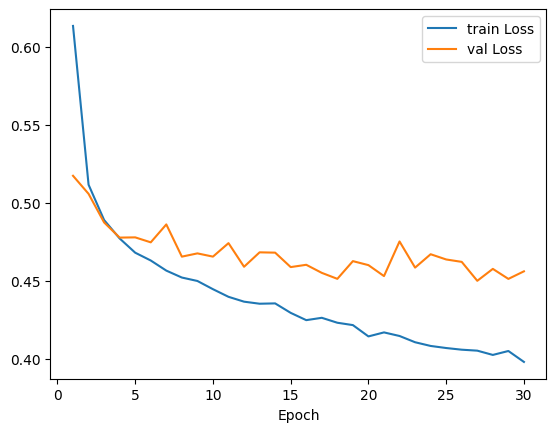

In [11]:
# Plot training and validation losses for the best models
plot_losses_LSTM = {
    'train Loss': best_train_losses_LSTM,
    'val Loss': best_valid_losses_LSTM
}

plot_losses_CNN = {
    'train Loss': best_train_losses_CNN,
    'val Loss': best_valid_losses_CNN
}

# Config string for filenames
config_best_model_LSTM = (
        f"width-{best_config_LSTM['width']}-lr-{best_config_LSTM['lr_rate']}"
        f"-dropout-{best_config_LSTM['dropout']}-layers-{best_config_LSTM['num_layers']}"
    )

config_best_model_CNN = (
        f"width-{best_config_CNN['width']}-lr-{best_config_CNN['lr_rate']}"
        f"-dropout-{best_config_CNN['dropout']}-layers-{best_config_CNN['num_layers']}"
    )

# take the range of epochs for x-axis
epochs_range = range(1, num_epochs + 1)

# Plot and save figures as PDF
utils_w_masking.plot(epochs_range, plot_losses_LSTM, filename=f'loss_LSTM-{config_best_model_LSTM}.pdf', ylim=None)
utils_w_masking.plot(epochs_range, plot_losses_CNN, filename=f'loss_CNN-{config_best_model_CNN}.pdf', ylim=None)

In [12]:
print(best_config_LSTM)
print(best_val_corr_LSTM)
print(best_config_CNN)
print(best_val_corr_CNN)

{'num_layers': 2, 'width': 128, 'dropout': 0, 'lr_rate': 0.001}
tensor(0.6502)
{'num_layers': 2, 'width': 128, 'dropout': 0.25, 'lr_rate': 0.0005}
tensor(0.5850)
